In [1]:
from Vizualizer import GeneralPresentator, PatternAnalyzer, DataPlotter
from Processing import DataProcessor
from FeatureEngineering import FeatureEngineer
from FeatureSelection import filter_correlated_variables
from scipy.fft import fft
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import plotly_express as px
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import calmap
import os
import sys
import warnings

sys.path.append("./packages/")
warnings.filterwarnings("ignore")


---

## 0. Import et mise en forme de la data

> Importation

In [2]:
DATA_PATH = './../data/'
TARGET = 'Global_active_power_Wh'

df = pd.read_csv(f'{DATA_PATH}household_power_consumption.txt',
                 sep=';',                            # separateur = ;
                 header=0,                           # ligne des header = 1ère ligne
                 low_memory=False,                   # parsing complet
                 infer_datetime_format=True,         # parsing des dates
                 )


> 0.2 Mise en forme des dtypes de date et création des variables de temps

Pour utiliser le dataframe dans l'exploration de données (EDA), nous avons effectué plusieurs opérations de prétraitement, notamment :

- Formatage de la date en format datetime pour faciliter les analyses temporelles.
- Conversion des variables numériques avec error="coerce" car le fichier source utilisait le symbole "?" pour représenter les valeurs manquantes.
- Ajout des variables jour, mois et année pour permettre des analyses plus granulaires.
- Optimisation de la mémoire en utilisant la fonction "downcasting" pour réduire la taille des données et accélérer les traitements.
- Conversion de la variable cible en watts/heure pour faciliter les comparaisons avec d'autres mesures.
- Création d'une nouvelle variable "other_submetering" pour regrouper les données provenant de différents sous-compteurs et faciliter les analyses sectorielles.

Ces opérations ont permis de préparer le dataframe pour les analyses ultérieures et de maximiser la qualité des résultats obtenus.

In [3]:
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

dp = DataProcessor(df)
df = dp.process_data(cols)
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_Wh,other_submetering
datetime,,,,,,,,,,,
2006-12-16 17:24:00,2006-12-16,17:24:00,4.214844,0.417969,234.875,18.406250,0.0,1.0,17.0,70.247398,52.247398
2006-12-16 17:25:00,2006-12-16,17:25:00,5.359375,0.436035,233.625,23.000000,0.0,1.0,16.0,89.322914,72.322914
2006-12-16 17:26:00,2006-12-16,17:26:00,5.375000,0.498047,233.250,23.000000,0.0,2.0,17.0,89.583336,70.583336
2006-12-16 17:27:00,2006-12-16,17:27:00,5.386719,0.501953,233.750,23.000000,0.0,1.0,17.0,89.778648,71.778648
2006-12-16 17:28:00,2006-12-16,17:28:00,3.666016,0.527832,235.625,15.796875,0.0,1.0,17.0,61.100262,43.100262


---

## 1. Explication du problème de machine learning que vous souhaitez résoudre


Georges Hebrail et Alice Berard, employés d'EDF travaillant dans le pôle R&D, ont mis à disposition des [données de consommation éléctrique](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#) des ménages de Sceaux, une ville située à 7km de Paris. Ces données couvrent la période du 16 décembre 2006 au 26 novembre 2010. Bien que ces données n'aient pas été associées à une problématique particulière et qu'aucun papier de recherche n'ait été publié sur ce sujet, nous les considérons comme une excellente base de départ pour notre projet de Deep Learning sur des séries temporelles.  

Nous imaginons trois possibles problématiques pour ce sujet:
- Prédire la puissance consommée active ;
- Prédire la puissance consommée réactive ;
- Prédire la puissance consommée apparente: $\sqrt(Global\_active\_power^2 + Global\_reactive\_power^2)$.

Dans tous les cas, l'objectif est d'optimiser la production d'électricité d'EDF en évitant la surproduction, ce qui permet de réduire les coûts et l'impact environnemental. En prévoyant les pics de consommation, il est également possible d'informer les ménages afin qu'ils puissent adapter leur consommation et réduire leur impact. 

Après la avoir effectué certaines recherches, nous avons appris que la puissance réactive est une puissance électromagnétique latente dans le réseau électrique, produite par des appareils tels que des bobines ou des moteurs. Cette énergie n'est pas facturée par EDF et suppose un coût, cependant elle est essentielle pour faire fonctionner ces types d'appareils. Cette puissance est stable dans le temps par construction et donc ça ne serait pas très intéressant de la prendre comme cible. De plus, si la cible était la puissance apparente, c'est à dire, la racine de la somme des deux puissances, la stabilité de la puissance réactive supposerait un problème pour la prédiction, la puissance réactive peut-être facilement découpée et elle ne supposerait qu'un bruit dans la cible, du fait de son oscillation (oscillation avec une distribution normale par le TCL).

Nous allons donc prédire la puissance consommée active, qui représente l'énergie effectivement transformée et utilisée par les ménages.  

Il est important de noter qu'il faut définir un horizon de prédiction. Pour cela, nous nous sommes intéressés au [parc électrique](https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/chiffres-cles-energie-2021/6-bilan-energetique-de-la-france#:~:text=Le%20bouquet%20%C3%A9nerg%C3%A9tique%20primaire%20r%C3%A9el,d%C3%A9chets%20et%202%20%25%20de%20charbon.) français. Nous avons appris que la production électrique peut s'adapter de quelques minutes à quelques heures si le changement n'est pas de plus de 50% de la production entre $t$ et $t+1$. Si c'était le cas, il faudrait arrêter la production nucléaire et cela pourrait prendre entre quelques heures à quelques jours. En conséquence de la rapide adaptation de la production, nous trouvons pertinent de prédire dans la minute. Cela vient s'appuyer sur le fait que l'énergie sur-produite est stockée dans des battéries, on considère donc une capacité parfaite d'adaptation. Nous serons donc très proches de ce qu'en finance est appelé "nowcasting" qui est de prédire dans la minute ou même dans la seconde qui vient.

**En conclusion:**
- *Cible* : puissance consommée active (Global_active_power) ; par la suite transformée en Global_active_power_Wh ;
- *Horizon* : $t$ sera à la minute.

*Note: le grand problème auquel nous allons être confrontés c'est de minimiser la surproduction et d'éviter (pénaliser) la sous production au maximum.*

---

## 2. Présentation du jeu de données



### Description du jeu de données de consommation électrique

Le jeu de données de consommation électrique est fourni par le pôle R&D d'EDF et contient les données de consommation électrique des ménages de Sceaux entre le 16 décembre 2006 et le 26 novembre 2010, à la minute près, pour un total de 2 049 280 observations. 

Il est important de noter que les données sont en format texte séparées par des points-virgules (;) et que les valeurs manquantes sont représentées par des champs vides. C'est pourquoi dans le point 0. nous avons travaillé sur le formatage du DataFrame pour avoir une bonne lecture de la base de données.

### Variables

La base de données brute est composée de 9 variables :  
- `Date` : La date (au format dd/mm/yyyy)
- `Time` : L'heure (au format hh:mm:ss)
- `Global_active_power` : La puissance active moyenne par minute dans l'ensemble du foyer (en kilowatts)
- `Global_reactive_power` : La puissance réactive moyenne par minute dans l'ensemble du foyer (en kilowatts)
- `Voltage` : La tension moyenne par minute (en volts)
- `Global_intensity` : L'intensité de courant moyenne par minute dans l'ensemble du foyer (en ampères)
- `Sub_metering_1` : Le sous-compteur d'énergie n°1 (en watt-heures d'énergie active). Il correspond à la cuisine, contenant principalement un lave-vaisselle, un four et un micro-ondes (les plaques de cuisson ne sont pas électriques mais alimentées au gaz).
- `Sub_metering_2` : Le sous-compteur d'énergie n°2 (en watt-heures d'énergie active). Il correspond à la buanderie, contenant une machine à laver, un sèche-linge, un réfrigérateur et un éclairage.
- `Sub_metering_3` : Le sous-compteur d'énergie n°3 (en watt-heures d'énergie active). Il correspond à un chauffe-eau électrique et un climatiseur.
- `other_metering`: Il correspond à tout autre consommation éléctrique (en watt-heures d'énergie active) = $(global\_active\_power*1000/60 - sub\_metering\_1 - sub\_metering\_2 - sub\_metering\_3)$

Comme mentionné, nous avons changé l'unité de la cible, la puissance active consommé à Watts/heure afin d'avoir les sub_metering qui sont dans la même unité et donc dont leur échelle sera comparable dans les analyses et dans le EDA. 

*Note : Il s'agit d'un problème de machine learning très particulier puisque toute les variables explicatives que nous avons sont soit une décomposition de la cible (sub_metering) soit le voltage et l'intensité qui par définition construisent la target.*

### 2.1 Analyse en profondeur du jeu de données

Dans cet aperçu de l'information de base, nous pouvons voir le type de données que nous allons traiter. En général, toutes les données sont numériques à l'exception des champs de temps et d'heure. Nous allons explorer la distribution des données plus en détail ultérieurement. De plus, nous constatons la présence de valeurs manquantes (NaN) qui devront être traitées afin de garantir la qualité de nos analyses.

In [4]:
gs = GeneralPresentator(df)

gs.print_basic_prez()


Column Names:
['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Global_active_power_Wh', 'other_submetering']

Data Types:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_Wh,other_submetering
0,datetime64[ns],category,float16,float16,float16,float16,float16,float16,float16,float32,float32



Basic Statistics:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_Wh,other_submetering
count,2.049280e+06,2.049280e+06,2049280.000,2.049280e+06,2049280.0,2049280.0,2049280.0,2.049280e+06,2.049280e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.819355e+01,9.314665e+00
std,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.0,0.0,0.0,1.762157e+01,9.585917e+00
min,7.598877e-02,0.000000e+00,223.250,1.999512e-01,0.0,0.0,0.0,1.266479e+00,-2.404947e+00
25%,3.081055e-01,4.800415e-02,239.000,1.400391e+00,0.0,0.0,0.0,5.135091e+00,3.802734e+00
50%,6.020508e-01,9.997559e-02,241.000,2.599609e+00,0.0,0.0,1.0,1.003418e+01,5.501302e+00
75%,1.528320e+00,1.939697e-01,242.875,6.398438e+00,0.0,1.0,17.0,2.547201e+01,1.036914e+01
max,1.112500e+01,1.389648e+00,254.125,4.840625e+01,88.0,80.0,31.0,1.854167e+02,1.248385e+02



Missing Values:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_Wh,other_submetering
0,0,0,25979,25979,25979,25979,25979,25979,25979,25979,25979



Sample Data:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_Wh,other_submetering
datetime,,,,,,,,,,,
2006-12-16 17:24:00,2006-12-16,17:24:00,4.214844,0.417969,234.875,18.406250,0.0,1.0,17.0,70.247398,52.247398
2006-12-16 17:25:00,2006-12-16,17:25:00,5.359375,0.436035,233.625,23.000000,0.0,1.0,16.0,89.322914,72.322914
2006-12-16 17:26:00,2006-12-16,17:26:00,5.375000,0.498047,233.250,23.000000,0.0,2.0,17.0,89.583336,70.583336
2006-12-16 17:27:00,2006-12-16,17:27:00,5.386719,0.501953,233.750,23.000000,0.0,1.0,17.0,89.778648,71.778648
2006-12-16 17:28:00,2006-12-16,17:28:00,3.666016,0.527832,235.625,15.796875,0.0,1.0,17.0,61.100262,43.100262


---

## 3. Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

Il peut s'avérer très utile d'effectuer une analyse exploratoire de données pour comprendre les tendances globales de la consommation d'énergie, telles que les fluctuations saisonnières, les variations entre les jours de la semaine et les week-ends, et les comportements de consommation à long terme. Cette analyse peut être effectuée à différentes échelles de temps, allant de l'heure près, au quotidien, à l'hebdomadaire ou encore au mensuel, en fonction de la résolution temporelle des données disponibles et des objectifs de l'analyse.

En comprenant les tendances globales, les schémas saisonniers et les comportements de consommation, il est possible de mieux anticiper la demande future d'énergie et d'adapter la production d'énergie en conséquence. Cette compréhension peut également aider à informer les politiques énergétiques et les pratiques de tarification qui encouragent les comportements de consommation éco-responsables.


### to do: sortir la proportion entre metering par mois

In [5]:
dataplots = DataPlotter(df)


> Pandas Profiling


En regardant le pandas profiling nous pouvons voir:

- *Données dupliquées* : il s'agit des zéros, ils sont considérés comme dupliqués mais l'index n'est cependant pas le même, cela ne suppose donc pas un problème. 
- *Zéros* : il s'agit de problèmes de production dans le système éléctrique. 
- *Variables qui sont fortement corrélées* : par la suite pour la construction du modèle nous avons construit une fonction de séléction de variables qui prend en compte la corrélation à la cible et la corrélation entre variables en gardant que les variables qui sont le plus corrélés à la target et en évitant la corrélation entre elles.

**Distribution des variables:**
Nous pouvons voir que les distributions ont en générale une skewness positive. Cela est tout à fait normal, il y a quelques jours ou la consommation éléctrique peut-être très très élevé surtout en hiver où on reste plus à la maison, on chauffe la maison, on cuisine et on fait des machines. Les jours très froids même si rares à Scéaux ils sont quand même présent quelques fois par an. Ces consommation sont les consommation vraiment à l'extrême de la distribution. mais en général, la consommation est plus modérée. 

La distribution avec une skewness positive est donc normal et présente dans les variables: 
- `global_active_power`
- `global_reactive_power`
- `global_intensity`
- `global_active_power`
- `other_submetering`

Une distribution normale est présente pour le `voltage`, c'est normal par construction (grandeur physique). 

Des distributions particulières:
- `Sub_metering_3`: consommation ou très forte ou très faible, essentiellement le chauffage et donc corrélé à la temperature et en moins mesure à la saison.
- `Sub_metering_2`: Très proche du nul, en effet, la buanderie ne constitue pas une dépense énergetique majeur et est constant au cours des saisons et du temps. On peut prévoir que cette variable constante n'impactera donc pas le modèle dans une grande mesure. Comme nous verrons par la suite, c'est une consommation speciallement présente les week-end et donc l'impact de cette consommation sera probablement pris par la variable week-end que nous allons créer.
- `Sub_metering_1`: Une consommation faible mais très présente, quasiement tous les jours. Une consommation très forte mais pas très présente. Par exemple, les familles qui préparent les repas de la semaine les week-end.

**Interactions entre variables:**  
Spécialement la cible ne présente pas des rélations non-linéaires. Nous pouvons anticiper une bonne précision des modèles naïfs par la suite. Encore une fois, c'est normal puisque toutes les variables sont à une transformation prêt de la cible. 

**Corrélations:**
Sauf le voltage qui est constant au fil du temps, les reste des variables sont assez corrélées. 

In [6]:
# dataplots.data_profiling(granularity="3M")


> Calendar overview

In [7]:
# create the treemap
# fig = px.treemap(df, path=["year", "month", "day"], values="Global_active_power")

# show the plot
# fig.show()


> Calendar plots

Lorsqu'on étudie la consommation électrique totale, il est évident qu'elle est fortement influencée par les saisons. En effet, durant l'hiver, la demande en énergie augmente considérablement en raison du chauffage, car il s'agit d'une ville plutôt froide. En revanche, pendant l'été et les périodes de vacances, la demande diminue. Malgré ces variations saisonnières importantes, la consommation électrique reste globalement stable d'une année sur l'autre, bien que l'on remarque une légère hausse de la demande les week-ends.

Il convient également de souligner que le chauffage représente la majeure partie de la consommation électrique. Cette observation souligne l'importance de comprendre l'impact des conditions météorologiques sur la demande d'énergie et les stratégies d'efficacité énergétique qui pourraient être mises en place pour réduire la consommation d'énergie liée au chauffage.

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

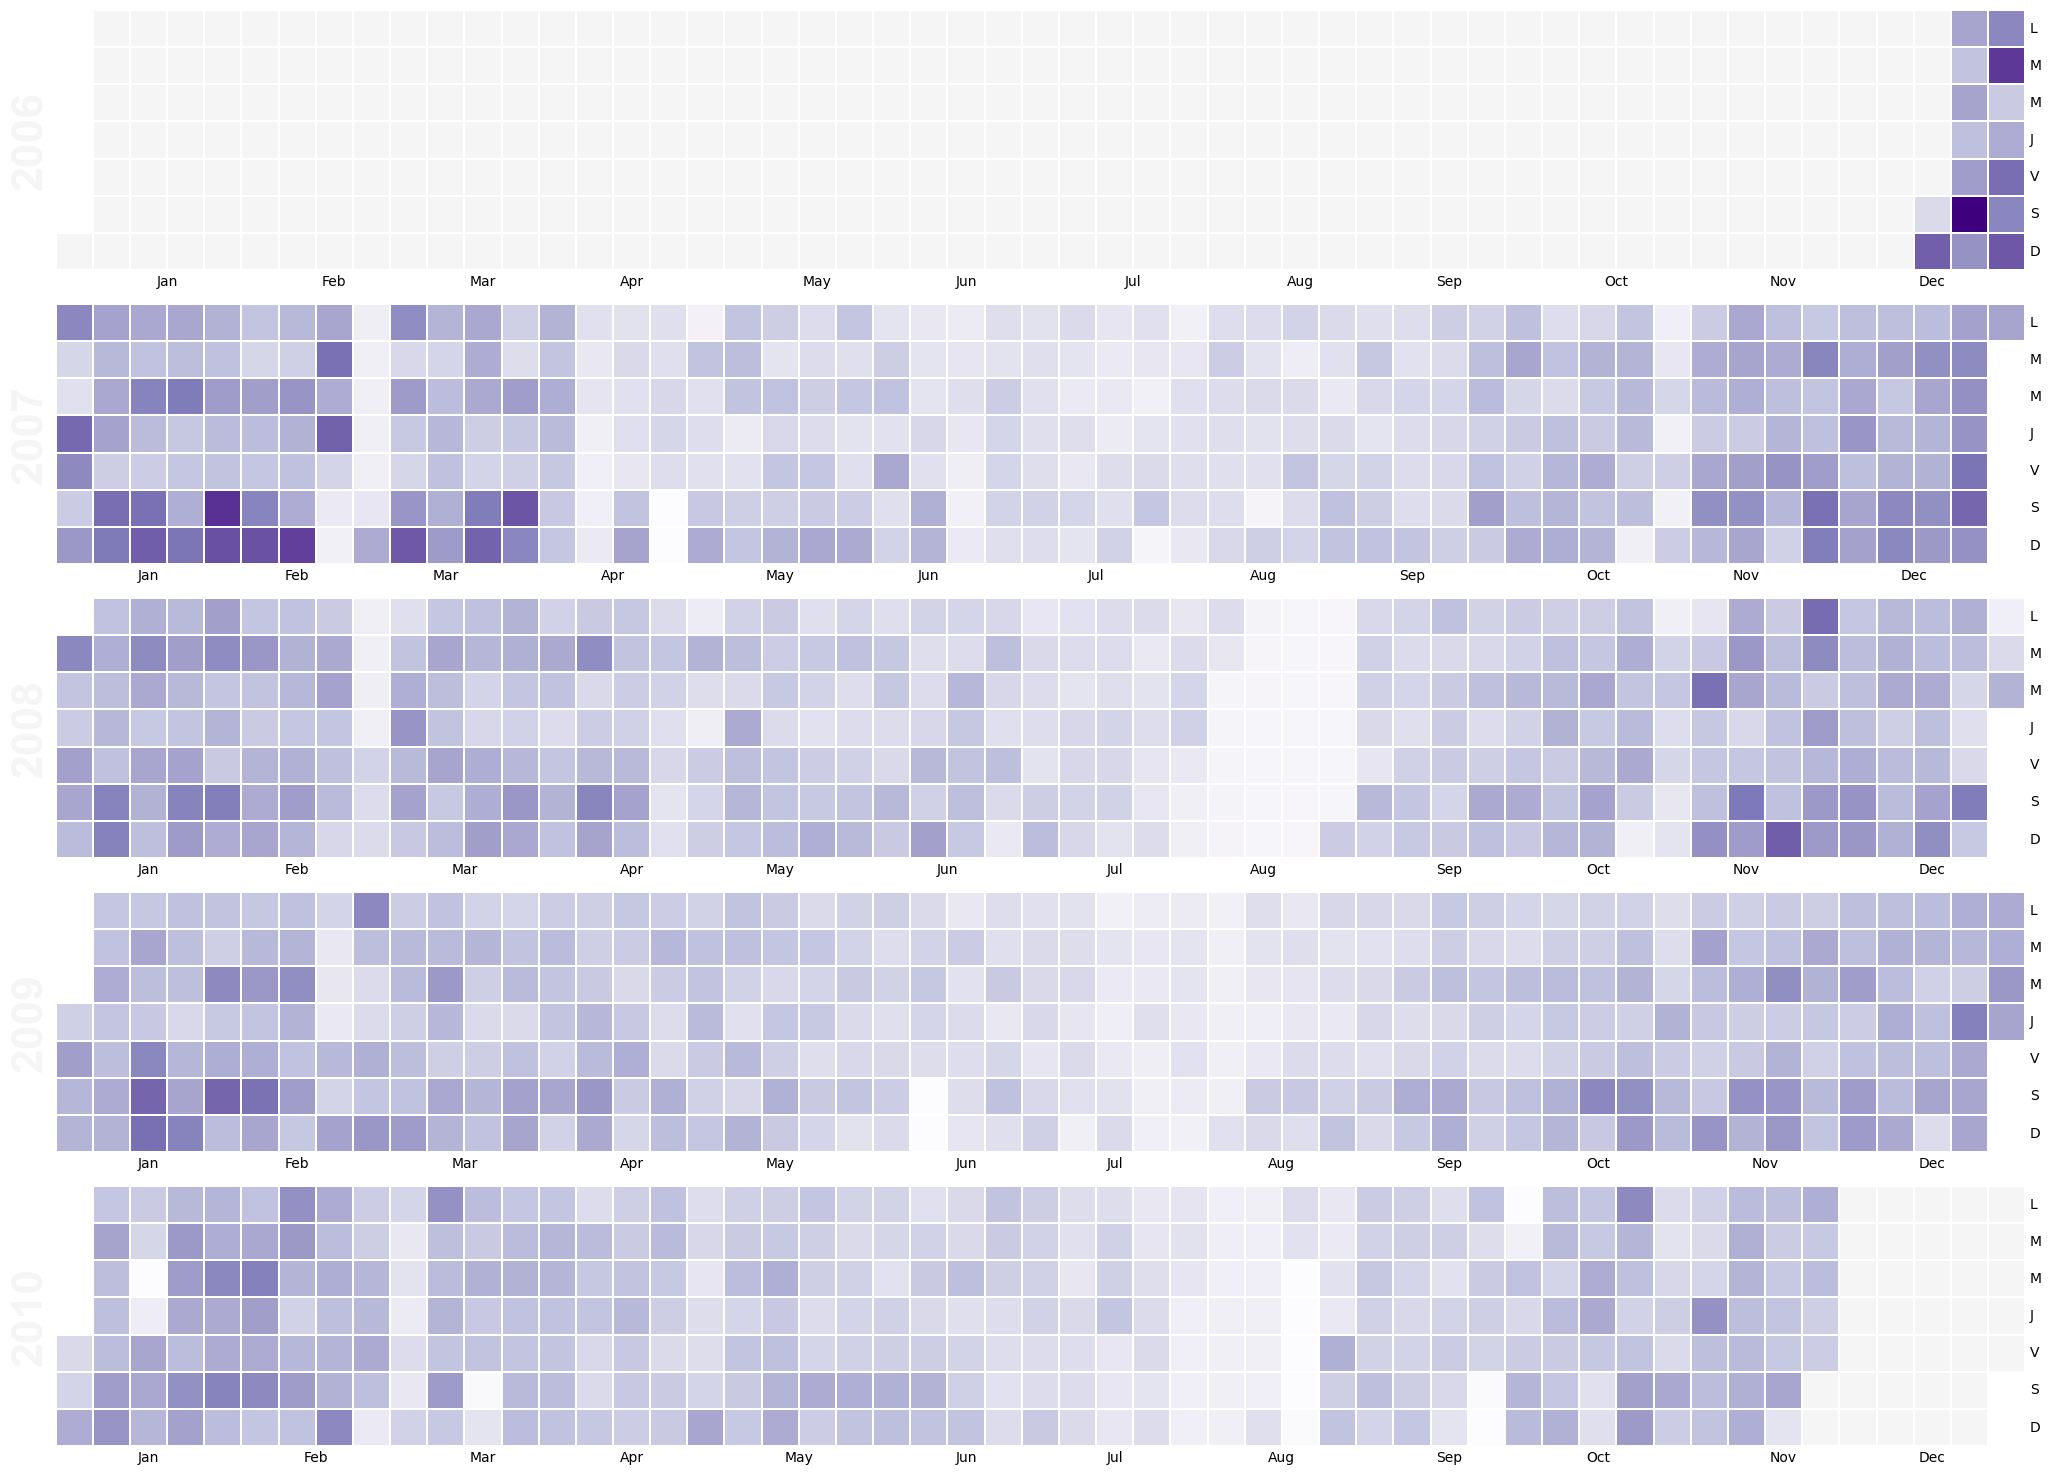

In [8]:
calmap.calendarplot(df[TARGET], monthticks=3, daylabels='LMMJVSD', cmap='Purples',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


En examinant de plus près le sous-comptage de l'électricité dans la cuisine, nous pouvons observer une tendance intéressante : une augmentation de la consommation électrique les week-ends, tandis que celle-ci diminue pendant les vacances et l'été. Cependant, il y a certains jours où la consommation d'énergie augmente sensiblement, et nous pouvons supposer qu'il s'agit des jours fériés.

Cette observation suggère que les habitudes de consommation électrique dans la cuisine sont influencées par les rythmes de vie des occupants de la maison, avec une augmentation de la demande d'électricité pendant les week-ends lorsque les gens ont plus de temps libre et passent plus de temps chez eux. L'impact des jours fériés sur la consommation d'électricité dans la cuisine peut également être lié aux habitudes alimentaires et aux activités de loisirs spécifiques à ces occasions. Ces résultats soulignent l'importance de comprendre les facteurs qui influencent la demande d'énergie et de développer des stratégies pour encourager des comportements de consommation plus durables.

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

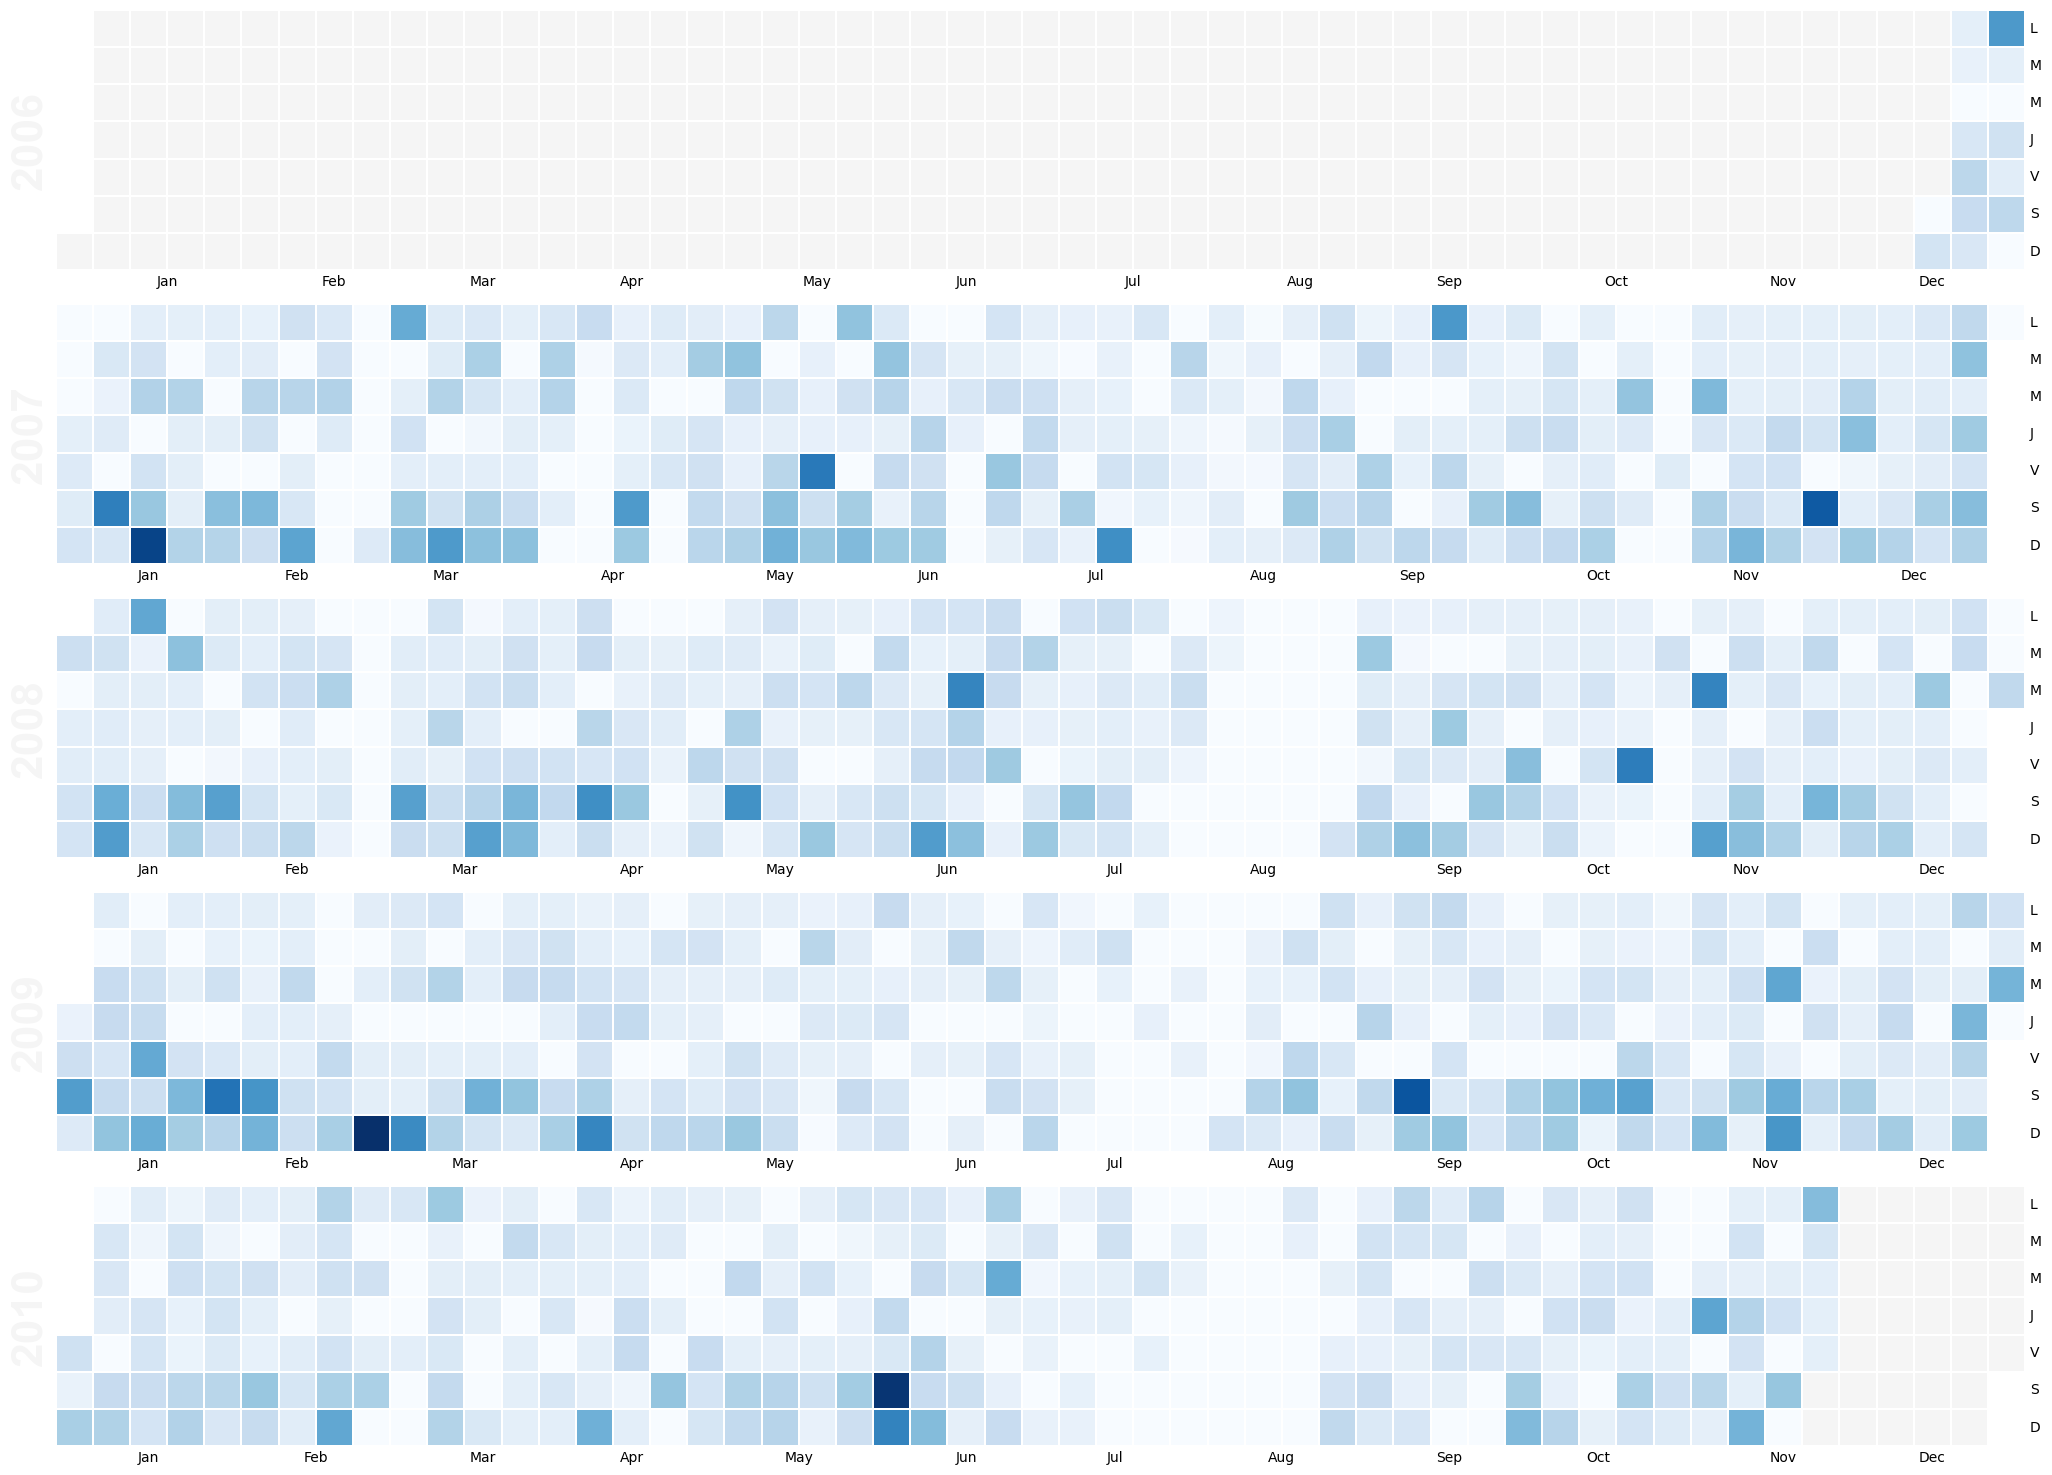

In [9]:
calmap.calendarplot(df['Sub_metering_1'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


L'analyse du sous-comptage de l'électricité dans la buanderie révèle une tendance marquée : une consommation électrique plus élevée les mercredis, suivie dans une moindre mesure par les mardis, et une augmentation significative le week-end.

Ces résultats semblent cohérents avec le comportement général de la population, qui pourrait consacrer les mercredis à la lessive et au ménage, et accorder davantage de temps libre aux activités domestiques le week-end. 

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

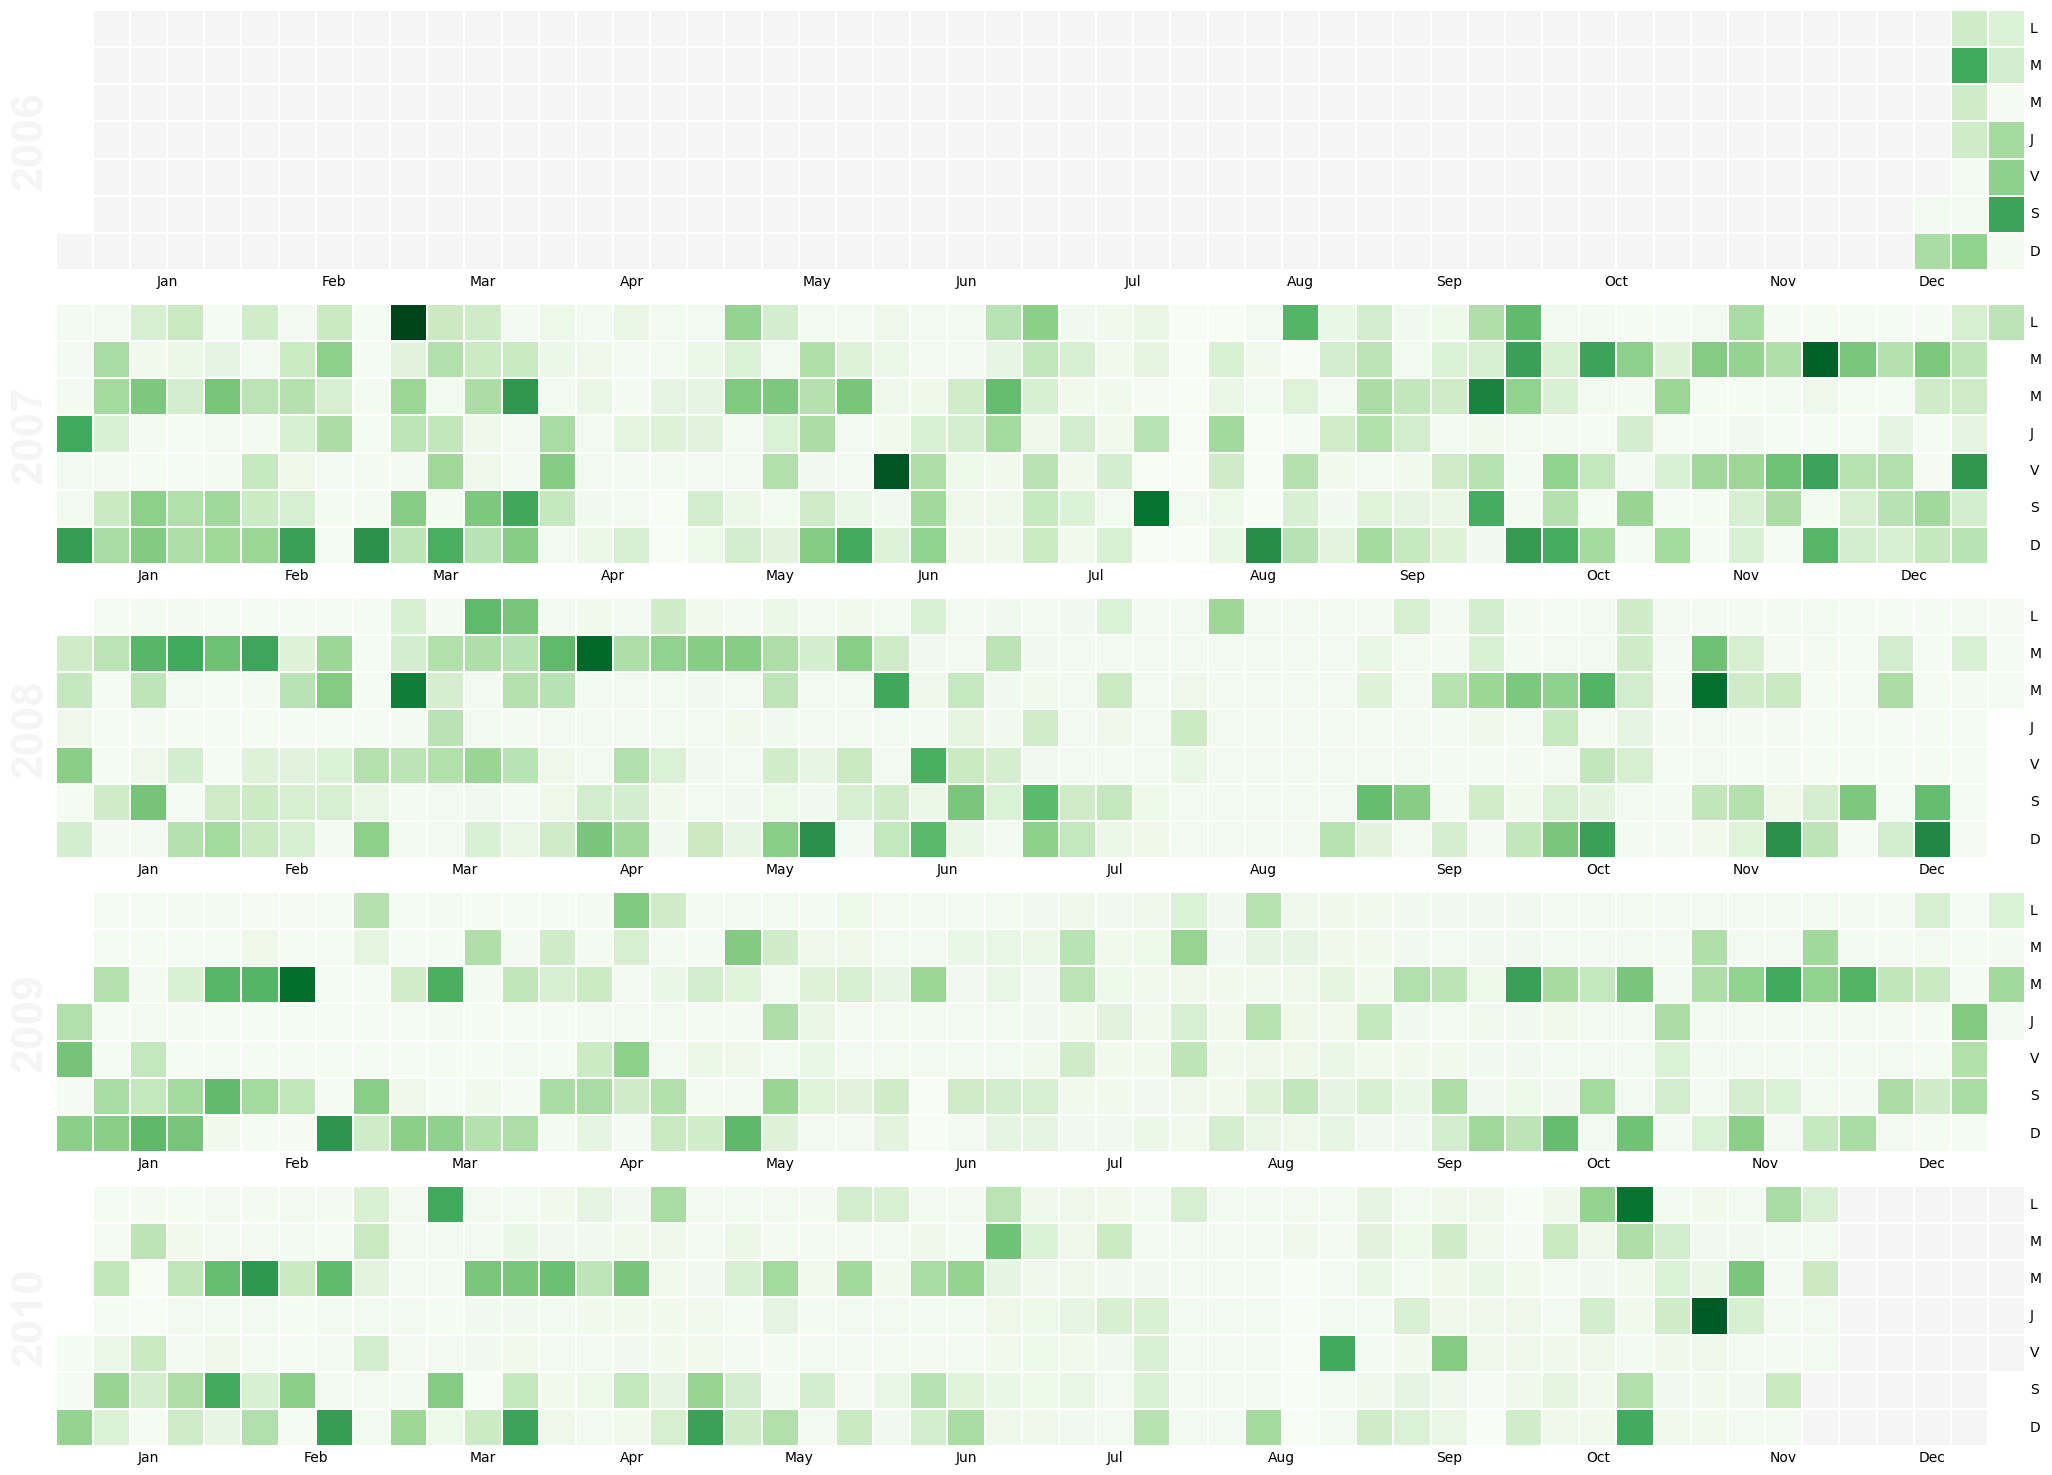

In [10]:
calmap.calendarplot(df['Sub_metering_2'], monthticks=3, daylabels='LMMJVSD', cmap='Greens',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


L'analyse du sous-comptage d'électricité dans le troisième sous-compteur suggère que la ville est particulièrement froide, avec une forte consommation d'électricité en hiver et pendant les jours froids. Cette saisonnalité peut nous aider à anticiper la consommation d'énergie des ménages dans les prochains jours.

Cependant, l'absence de consommation en été indique également que la ville n'a pas besoin de climatisation pendant cette période. La prise en compte de ces tendances saisonnières est essentielle pour comprendre les habitudes de consommation d'énergie et concevoir des stratégies efficaces de gestion de la demande.

Malheureusement, nous n'avons pas pu intégrer les données de prévision météorologique pour Scéaux en 2006 avec une granularité horaire pour la température. Cependant, l'introduction de ces données pourrait être très intéressante pour affiner les prévisions de consommation d'énergie et améliorer les stratégies d'efficacité énergétique à l'avenir.

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

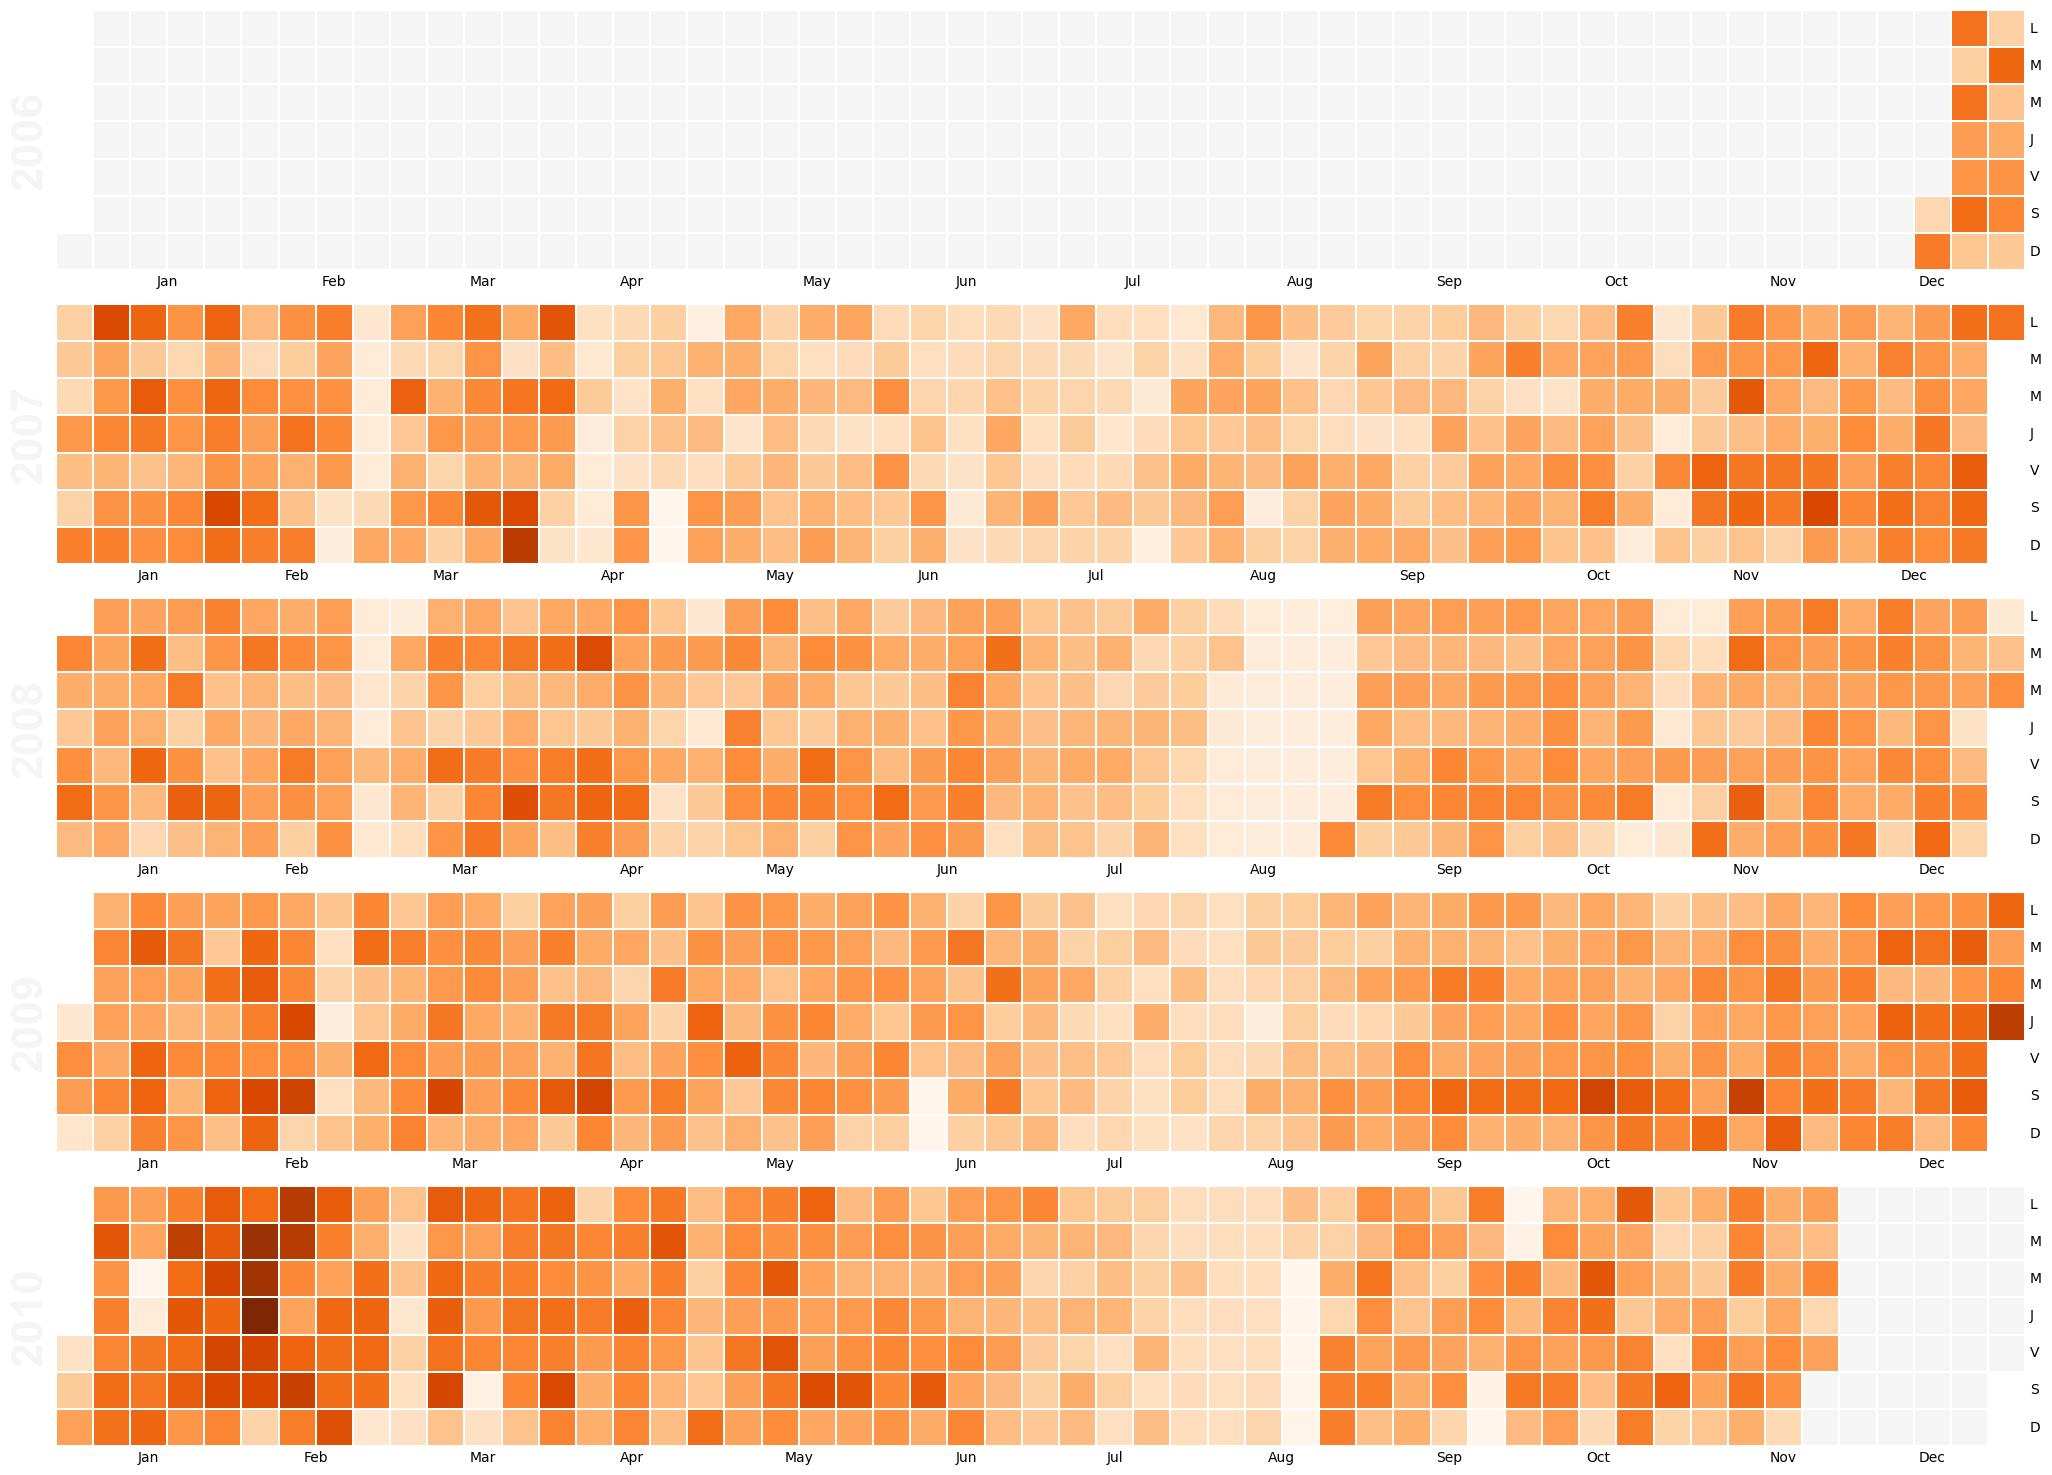

In [11]:
calmap.calendarplot(df['Sub_metering_3'], monthticks=3, daylabels='LMMJVSD', cmap='Oranges',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


L'examen des données révèle une constance de la consommation d'électricité, avec une faible saisonnalité en été et l'absence de saisonnalité à une granularité journalière.

Cela suggère que les habitudes de consommation d'énergie des occupants de la maison restent relativement stables tout au long de l'année et que les variations saisonnières observées sont principalement liées à des facteurs extérieurs, tels que la météo et les jours fériés.



(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

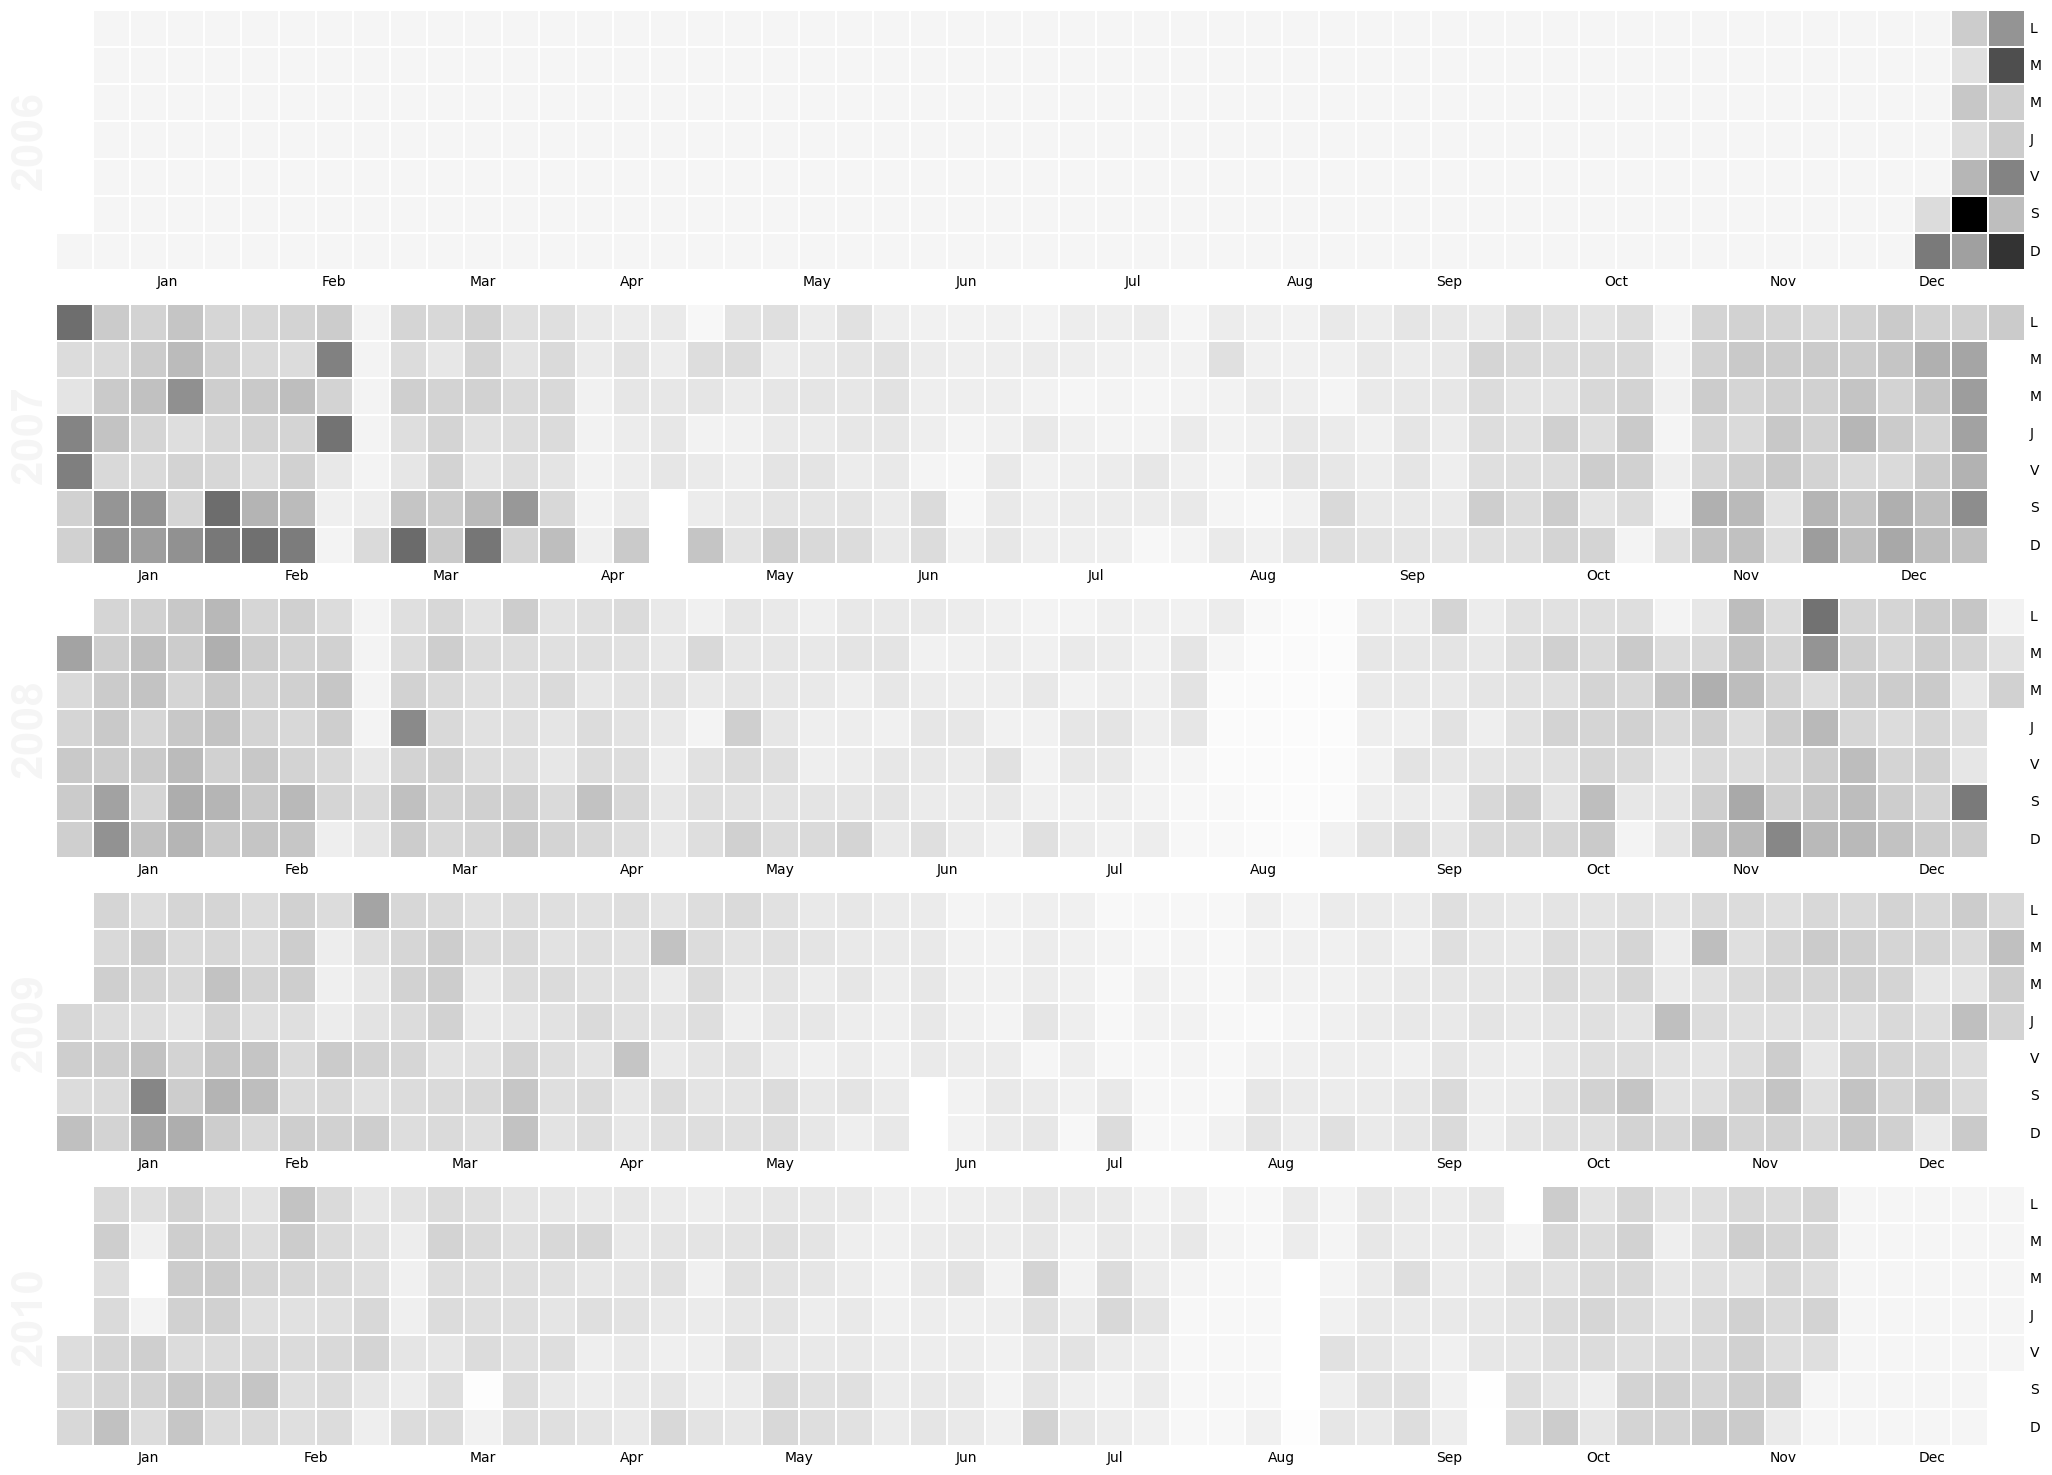

In [12]:
calmap.calendarplot(df['other_submetering'], monthticks=3, daylabels='LMMJVSD', cmap='Greys',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


### 3.3 Visualisation des time series

L'examen de la consommation d'électricité sur une base trimestrielle avec une granularité grossière révèle que bien que la demande électrique globale soit très saisonnière, la consommation électrique de la cuisine et de la buanderie ne le sont pas. Cependant, si nous examinons les données à une granularité plus fine, c'est-à-dire par heure, toutes les consommations présentent une certaine saisonnalité.

Ces variations saisonnières pourront être prises en compte dans un futur modèle de prédiction en ajoutant des variables saisonnières telles qu'une variable binaire pour l'été ou l'hiver. L'idée est que ces variables auront un poids dans le modèle pour nous permettre d'anticiper la consommation future. Cette observation suggère également que l'utilisation d'un modèle naïf saisonnier pourrait être très performant dans notre cas, en raison de la forte saisonnalité des données.

La prise en compte de ces variations saisonnières dans les modèles de prédiction de la consommation d'énergie peut aider à améliorer l'efficacité énergétique et à réduire les coûts en anticipant les périodes de demande élevée et en adaptant la production et la distribution d'énergie en conséquence.







In [13]:
# Suppression de la feature voltage et year pour observer les autres features
cols = list(df.columns)
viz_cols = [i for i in cols if i not in [
    'Date', 'Time', 'Voltage', 'year', 'day', 'month']]


> Plotting des times series

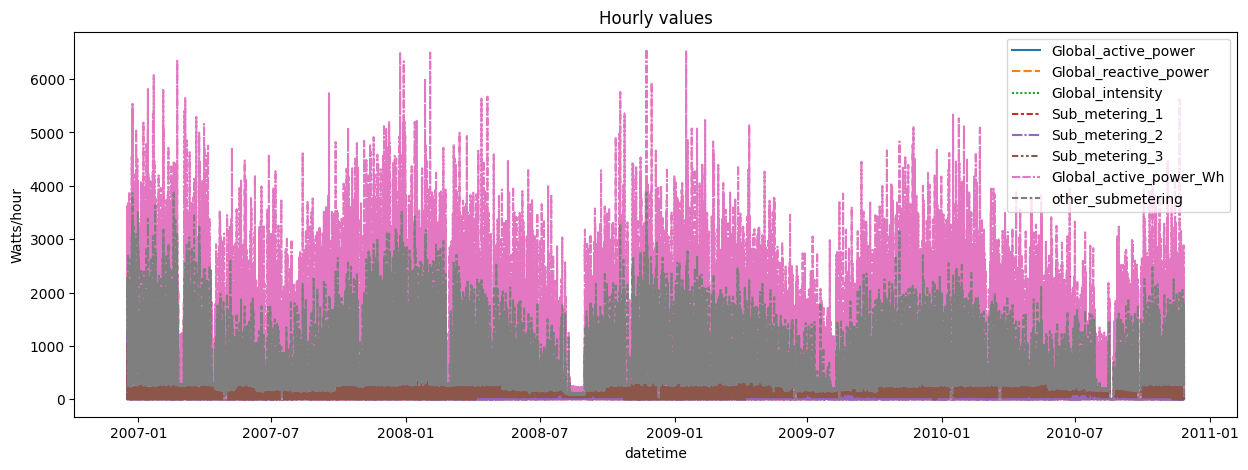

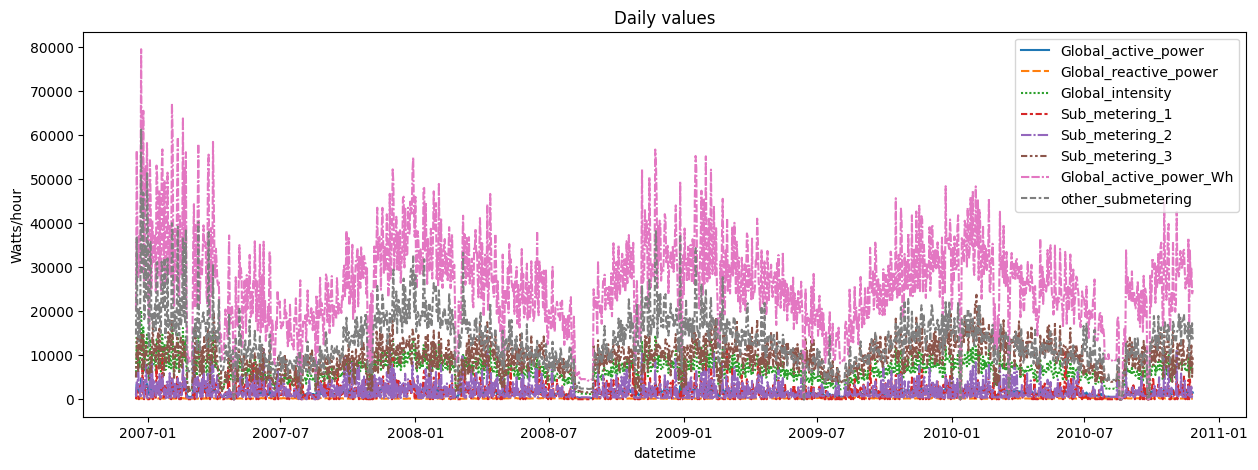

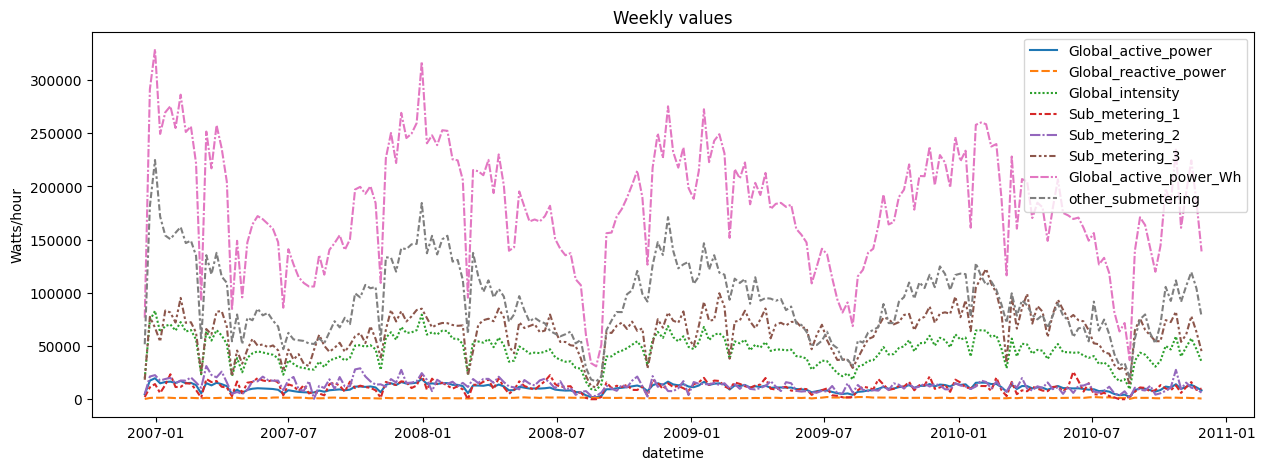

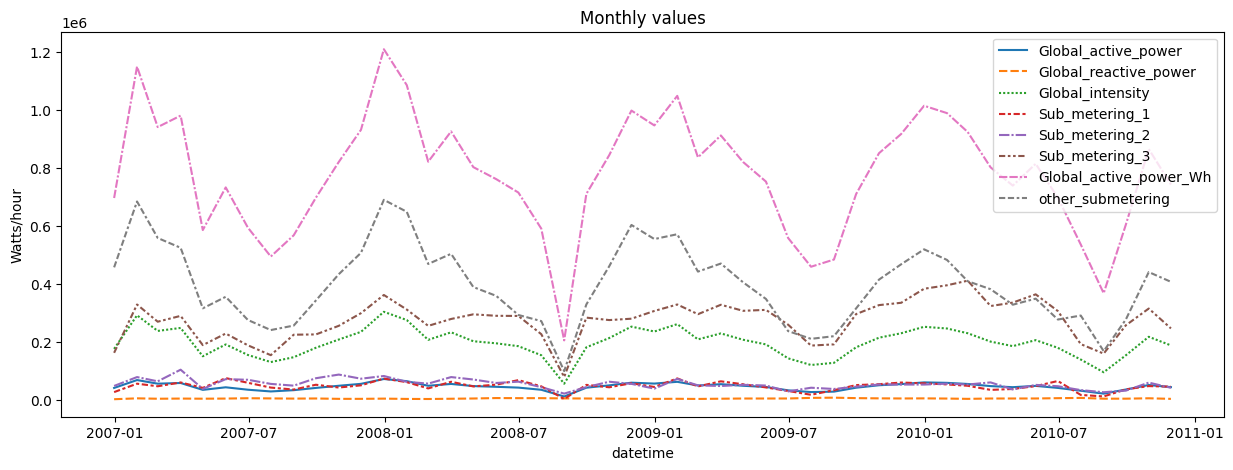

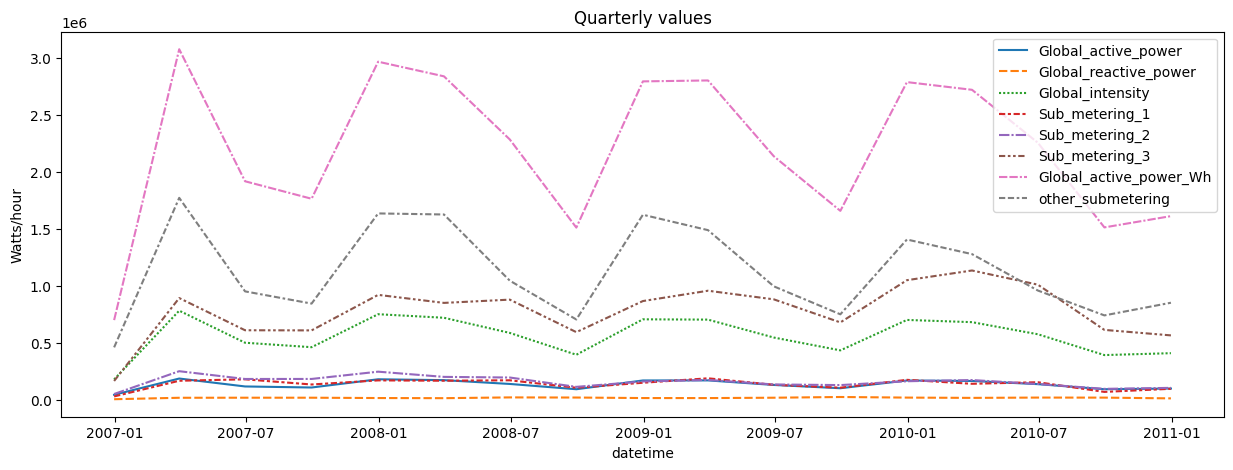

In [14]:
dataplots.plot_time_series(column=viz_cols, granularity="all")


> Distribution plots

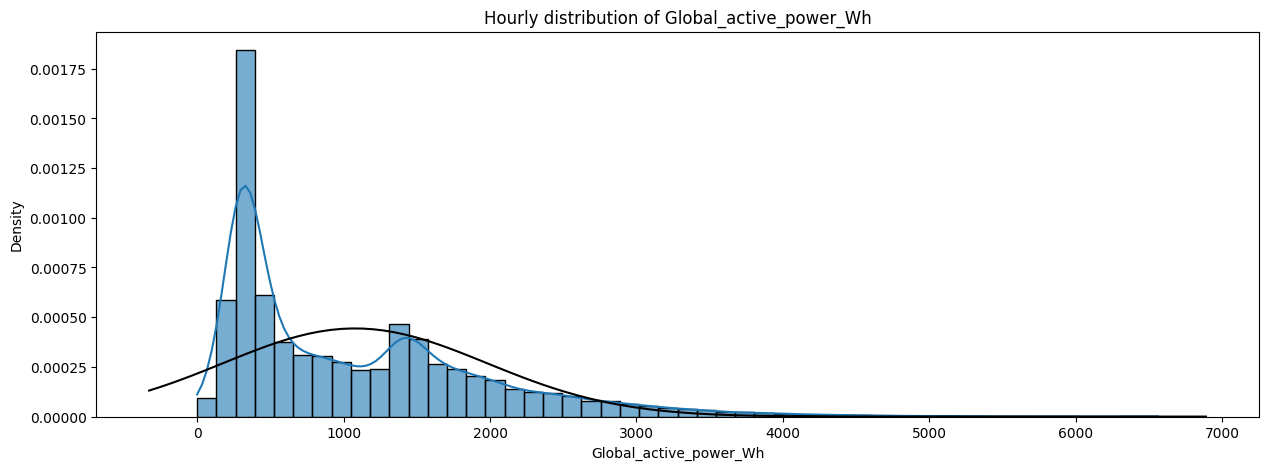

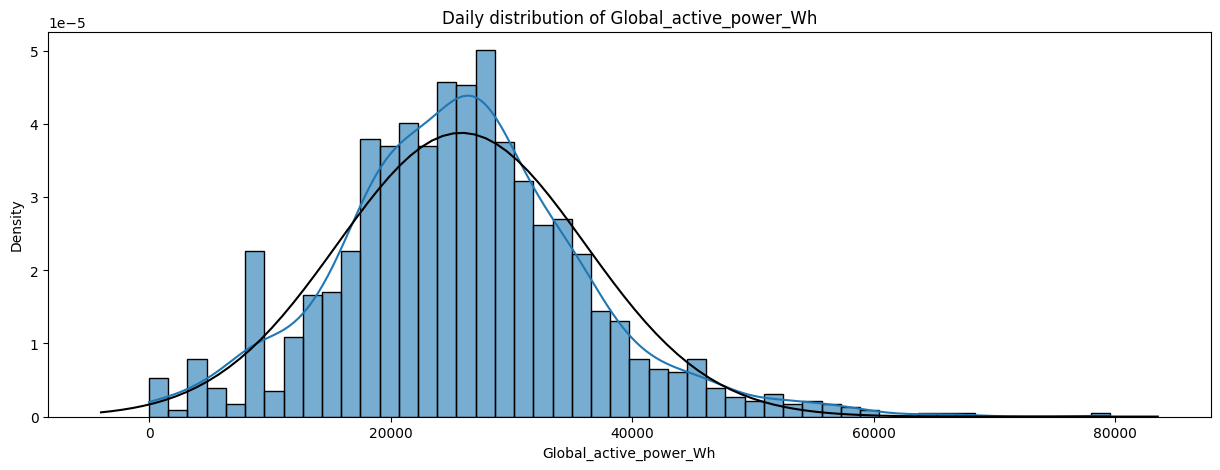

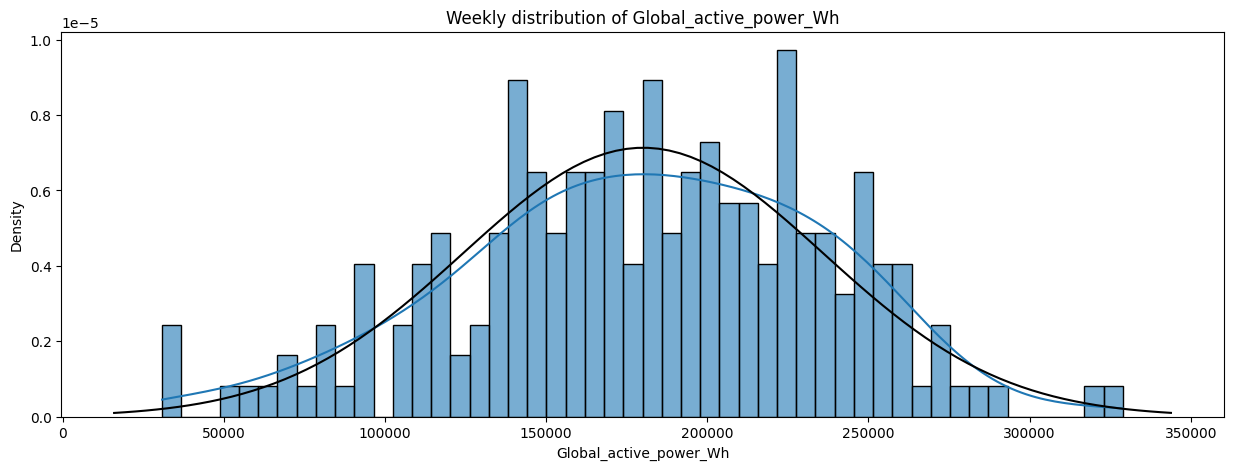

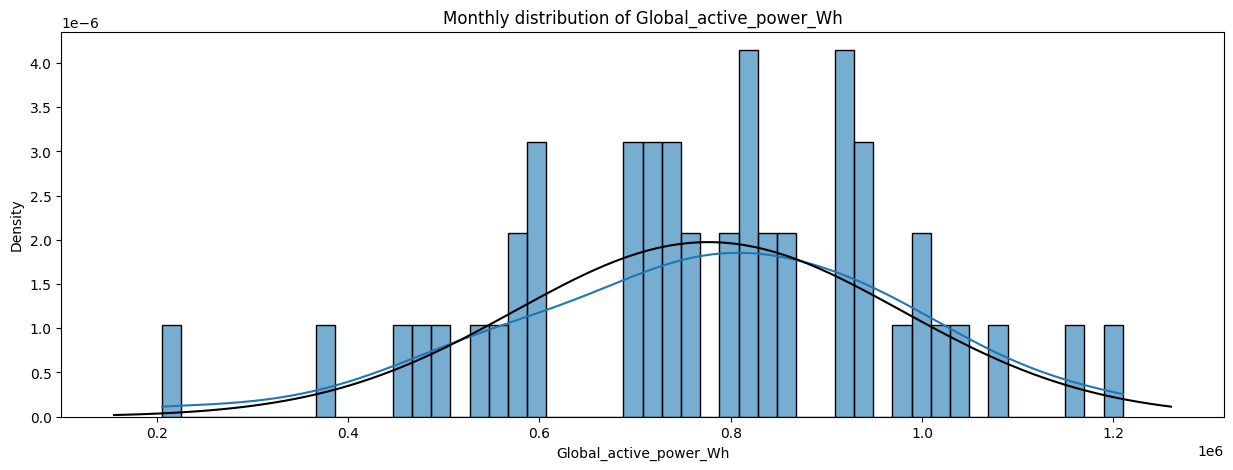

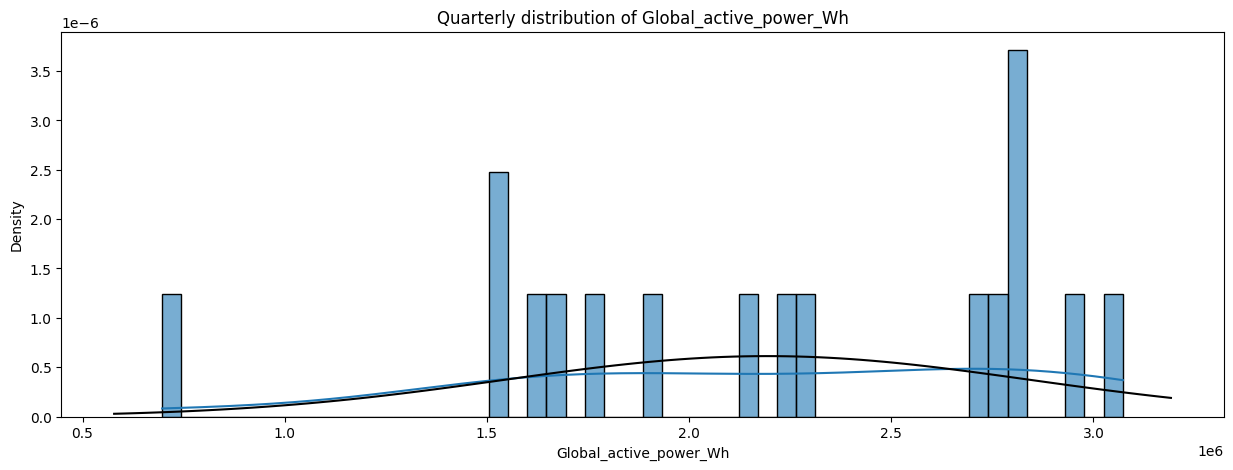

In [15]:
# Observation de la distribution de la puissance par rapport à une distribution Gaussienne
dataplots.plot_histogram(TARGET, granularity="all")


>  Pairplots

Nous avons confirmé les résultats de l'analyse avec pandas profiling, qui montre une linéarité entre la variable cible et les variables explicatives.

Cette observation est importante car elle suggère que les variables explicatives sont significatives pour la prédiction de la consommation d'énergie et que nous pouvons utiliser des modèles de régression linéaire pour établir des prévisions fiables. Toutefois, il est important de noter que d'autres modèles, tels que les modèles non linéaires ou basés sur des arbres de décision, pourraient également être adaptés à notre jeu de données en fonction des caractéristiques spécifiques des données et des objectifs de prédiction.

In [16]:
# sns.pairplot(df[['Global_active_power', 'Global_reactive_power',
#              'Voltage', 'Global_intensity', 'Sub_metering_2', 'Sub_metering_3']])


> Probability plots

L'examen des plots de probabilités révèle l'absence de valeurs négatives, mais une sur-représentation de valeurs nulles qui contribuent à une queue de distribution plus importante. Cette distribution est fortement influencée par les contraintes du réseau électrique, ce qui peut expliquer cette tendance.

De plus, nous constatons une forte asymétrie avec des valeurs extrêmement élevées, qui correspondent probablement à des périodes de forte demande en énergie causées par des conditions météorologiques extrêmes, telles que des journées très froides.



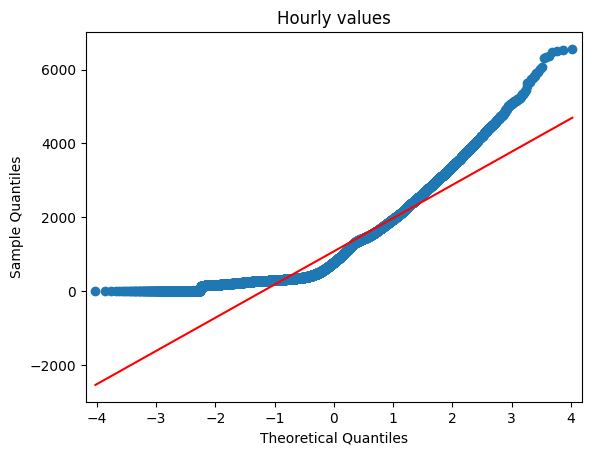

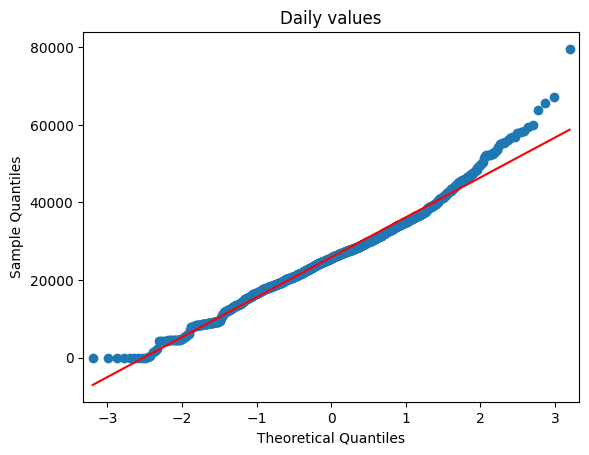

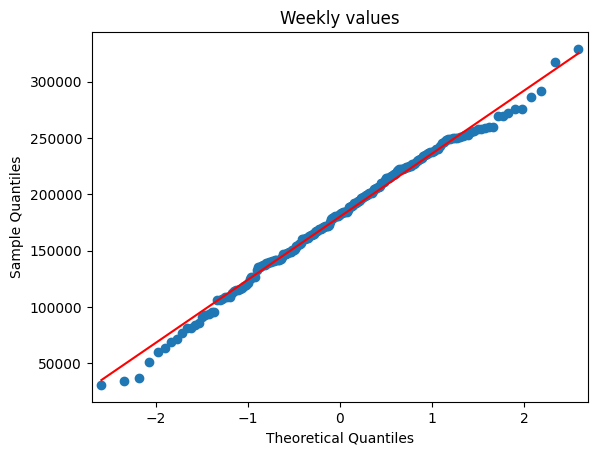

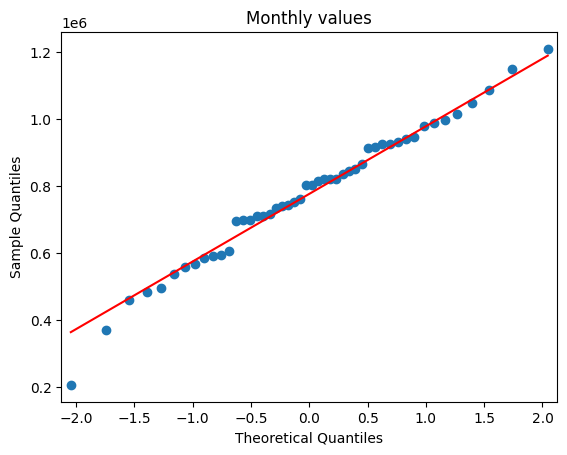

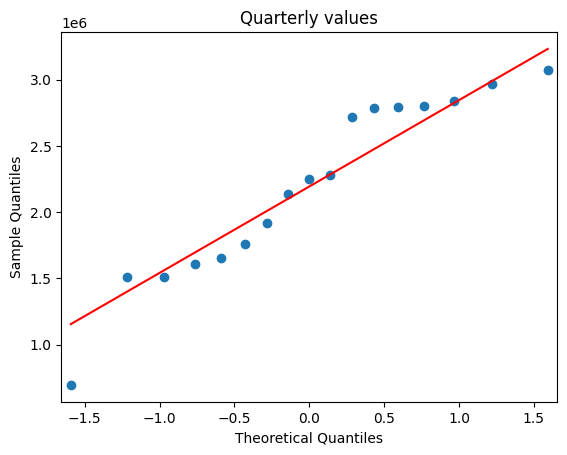

In [17]:
# Add probability plot for the column
dataplots.plot_prob(column=TARGET)


> Pattern analysis

En examinant les données à différentes granularités, nous pouvons constater que plus nous sommes précis dans la mesure de la consommation d'énergie, plus la série devient bruyante. Cette observation est en grande partie due à nos habitudes quotidiennes, telles que les cycles jour/nuit et les périodes d'activité et de repos, qui influencent la demande en énergie.

De plus, nous pouvons également observer des cycles plus longs qui se répètent, tels que les différences entre les jours de la semaine et les week-ends, ou les saisons d'hiver et d'été. Cette saisonnalité peut être particulièrement importante pour prévoir la demande future d'énergie et ajuster les stratégies de production et de distribution d'énergie en conséquence.

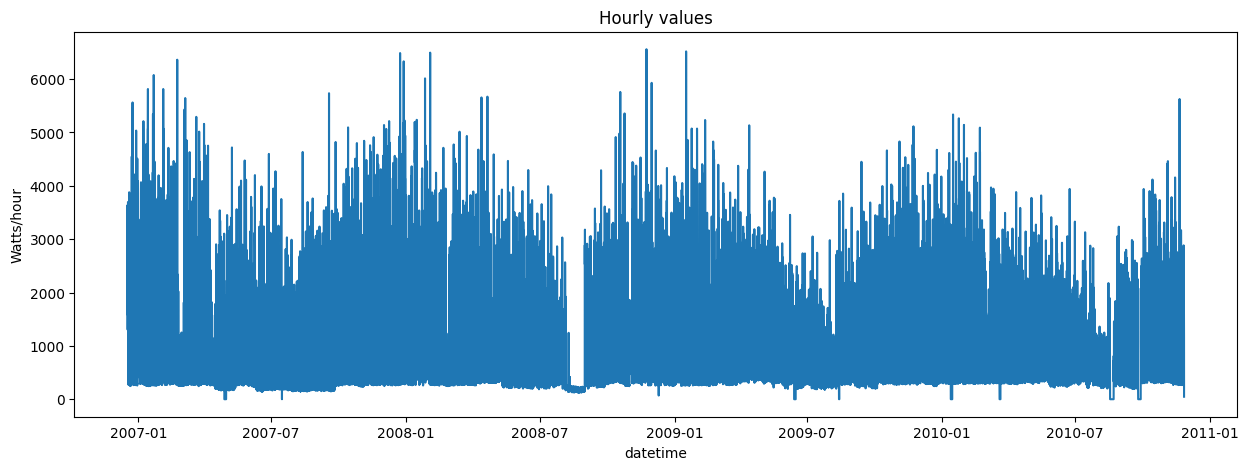

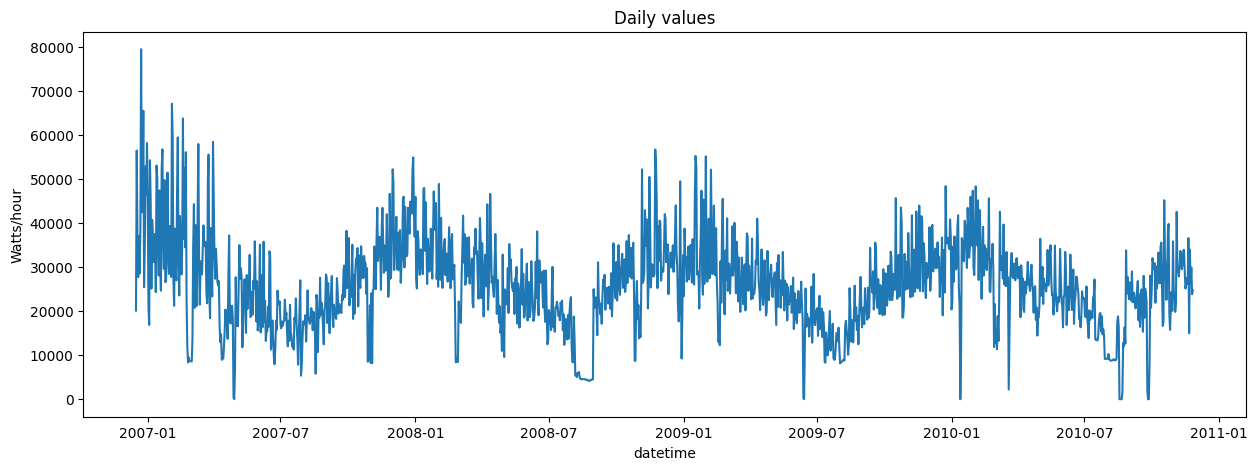

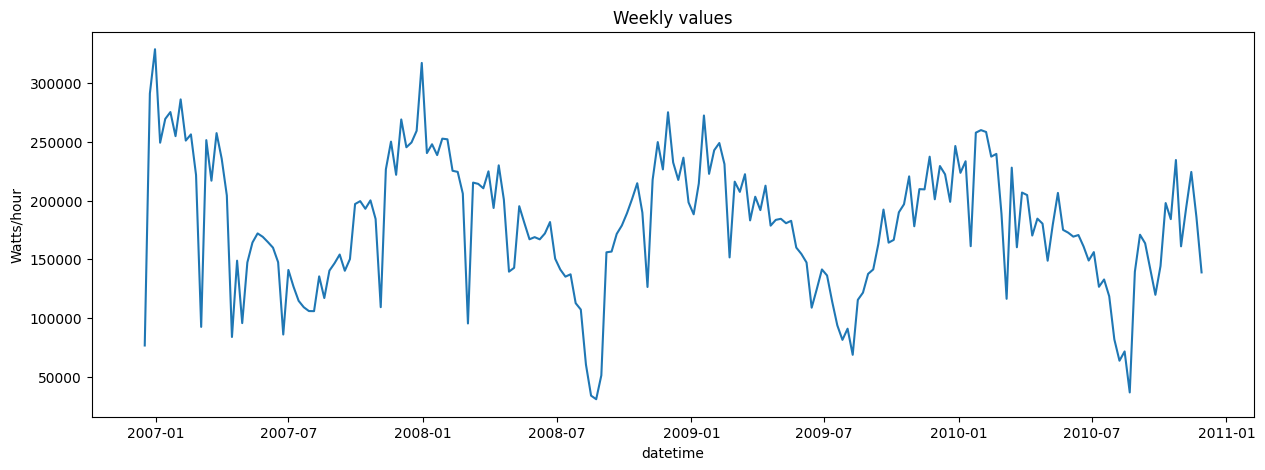

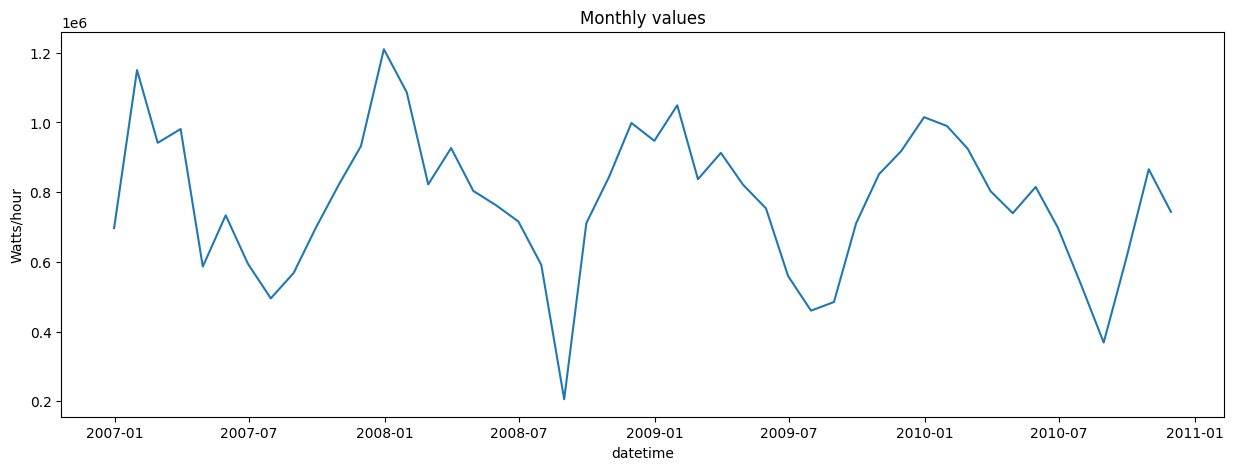

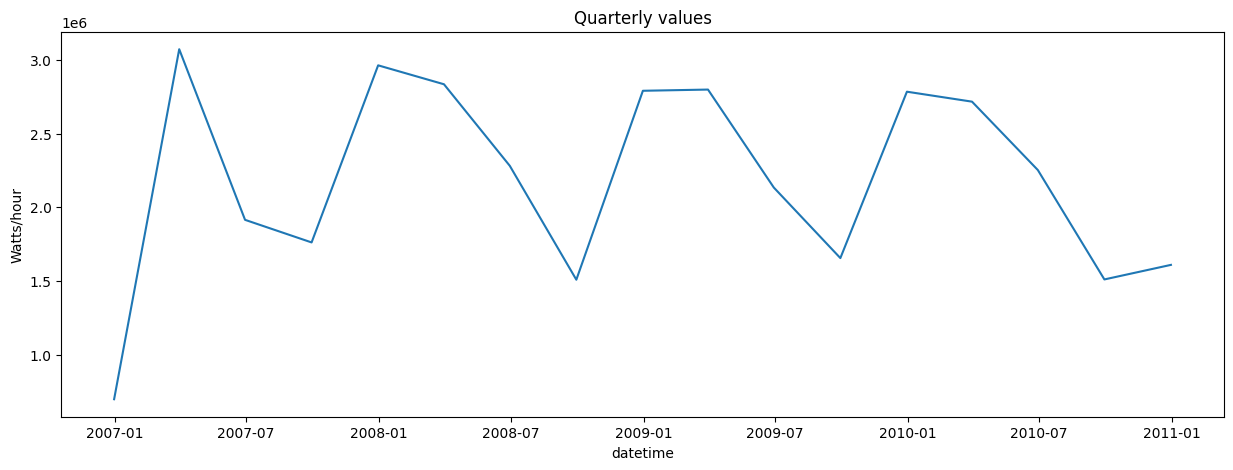

In [18]:
dataplots.plot_time_series(column=TARGET, granularity="all")


>  Breaking down the time variables to see patterns

Nous disposons d'une décomposition de la variable cible qui sera utilisée pour prédire la consommation d'énergie future. Cependant, il est important d'analyser toutes les variables disponibles pour déterminer les variables explicatives à utiliser dans la prédiction.

L'analyse de ces variables peut nous aider à comprendre les facteurs qui influencent la demande d'énergie et à identifier les variables les plus significatives pour la prédiction de la consommation d'énergie future.

In [19]:
analyzer = PatternAnalyzer(df)
sub_metering = ['Sub_metering_1', 'Sub_metering_2',
                'Sub_metering_3']


L'examen des plots révèle une forte saisonnalité, avec une demande d'énergie plus élevée en hiver et une demande plus faible en été. Cette tendance peut être attribuée à l'utilisation du chauffage en hiver, qui représente une grande partie de la consommation d'énergie dans les foyers.

En outre, nous constatons également des creux de consommation d'énergie pendant les vacances d'hiver et les vacances d'octobre/novembre. Cette observation suggère que les habitudes de consommation d'énergie des occupants de la maison varient en fonction des vacances scolaires et des périodes de congé, ce qui pourrait avoir un impact sur les prévisions de la demande d'énergie.



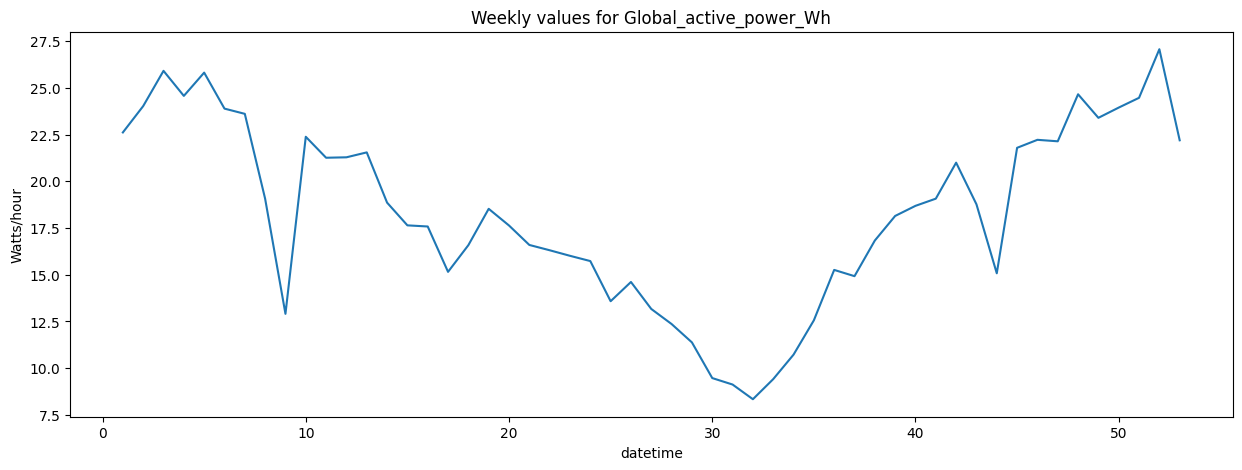

In [20]:
analyzer.plot_time_series(TARGET, "W")


Nous observons un pattern similaire pour les autres variables de consommation, en particulier pour le chauffage, qui représente la plus grande partie de la consommation d'énergie dans les foyers. Nous constatons également une stabilité relative de la consommation d'énergie pour la buanderie et la cuisine au fil du temps.

En outre, la stabilité relative de la consommation d'énergie pour la buanderie et la cuisine suggère que ces variables pourraient être moins influencées par les facteurs externes et les événements spécifiques que les autres variables de consommation. Cette observation peut avoir des implications pour le développement de stratégies d'efficacité énergétique ciblées sur ces zones spécifiques de la maison.

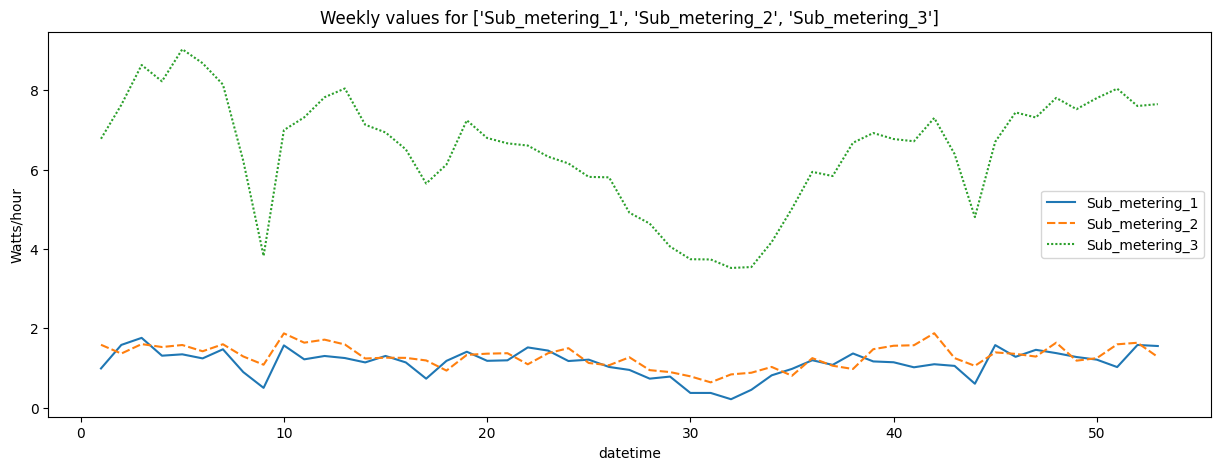

In [21]:
analyzer.plot_time_series(sub_metering, "W")


## 4. Data cleaning et imputation de données manquantes

In [26]:
# Nous avons des nan dans toutes les colonnes sauf la date
df.isna().any()


Date                      False
Time                      False
Global_active_power        True
Global_reactive_power      True
Voltage                    True
Global_intensity           True
Sub_metering_1             True
Sub_metering_2             True
Sub_metering_3             True
Global_active_power_Wh     True
other_submetering          True
dtype: bool

In [27]:
# On vérifie si c'est bien toute la ligne qui est nan et c'est bien le cas.
mask = df['Global_active_power_Wh'].isna()
df.loc[~mask].isna().any()


Date                      False
Time                      False
Global_active_power       False
Global_reactive_power     False
Voltage                   False
Global_intensity          False
Sub_metering_1            False
Sub_metering_2            False
Sub_metering_3            False
Global_active_power_Wh    False
other_submetering         False
dtype: bool

In [28]:
print("Comptage des NaN par colonne:")
print(df.isna().sum())

# Si bien cela peut paraître beaucoup, cela ne réprésente que 1,25% des observations.


Comptage des NaN par colonne:
Date                          0
Time                          0
Global_active_power       25979
Global_reactive_power     25979
Voltage                   25979
Global_intensity          25979
Sub_metering_1            25979
Sub_metering_2            25979
Sub_metering_3            25979
Global_active_power_Wh    25979
other_submetering         25979
dtype: int64


In [29]:
print(
    f'Nombre de jours qui présentent des NaN: {df[df["Global_active_power_Wh"].isna()]["Date"].nunique()}')


Nombre de jours qui présentent des NaN: 82


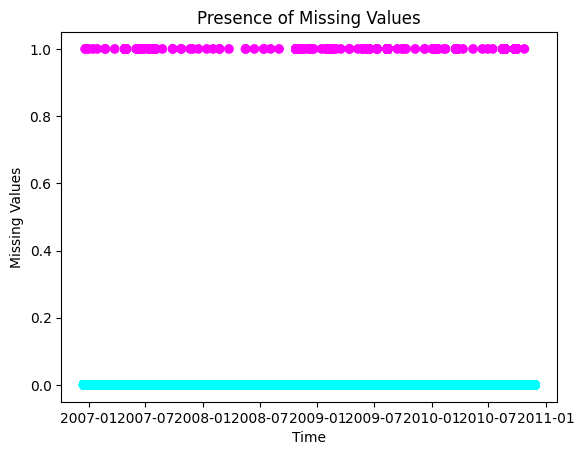

In [30]:
import matplotlib.pyplot as plt

df['missing'] = 0

mask = df['Global_active_power_Wh'].isna()
df.loc[mask, 'missing'] = 1

# Create a scatter plot with color-coded markers
plt.scatter(df.index, df['missing'], c=df['missing'], cmap='cool', marker='o')

# Set the axis labels and title
plt.xlabel('Time')
plt.ylabel('Missing Values')
plt.title('Presence of Missing Values')

# Show the plot
plt.show()


La distribution est normale, des NaN sont présent dans tous les dates. En conséquence, il est justifié de drop les valeurs manquantes.  

Une solution alternatice serait de réaliser un forward fill (ou un back fill), mais on préfère le premier car si on voulait prédire d'un jour à l'autre, on n'aurait pas l'information du lendemain et donc le back fill serait pas possible.  

Cependant, en vue que les NaN représentent des failles dans le système, nous allons drop les nan. Pourquoi ? Ils sont souvent présent dans plusieurs observations de suite et remplacer par une valeur constante n'est donc pas pertinent. Une méthode plus sophistiquée pourrait être mise en place tel que un ARIMA mais on considère cela inutile dans notre cas où on à 1% de valeur manquantes avec autant d'observations et le remplacement n'impacte pas les métriques du modèle. 

In [31]:
df.dropna(inplace=True)


---

## 5. Feature engineering

Nous avons dû apporter quelques modifications préliminaires telles que le downcasting, la création de variables ou le changement d'unités, qui auraient dû figurer dans cette partie, mais par souci de commodité, nous les avons décalées. De plus, nous avons créé certaines fonctionnalités telles que "is_winter" et "is_summer" (des variables saisonnières) afin de tenir compte des saisons dans le modèle et d'expliquer les baisses. Nous avons également ajouté des variables telles que "week-end" et "jours fériés" en France, sur la même logique.

Pour la création de lags, nous avons développé une petite fonction intégrée à la classe qui permet de choisir le lag souhaité et l'unité associée (par exemple, lag = [1,2,3,4], où les nombres peuvent représenter des jours, des heures ou des minutes). Nous avons cherché à généraliser autant que possible ces fonctions.

Il ne faut pas non plus oublier les variables spécifiques aux séries temporelles telles que les fenêtres glissantes et la conversion de l'heure en sinus afin de prendre en compte le caractère circulaire de l'heure.

In [32]:
fe = FeatureEngineer(df, TARGET)
df = df.drop(columns=["Date", "Time"])
df = fe.create_variables(lag=[1, 2, 3, 4], time="day", window_size=30)


In [33]:
df.columns


Index(['Date', 'Time', 'Global_active_power_Wh', 'missing', 'Date_lag1d',
       'Date_lag2d', 'Date_lag3d', 'Date_lag4d', 'Time_lag1d', 'Time_lag2d',
       'Time_lag3d', 'Time_lag4d', 'Global_active_power_lag1d',
       'Global_active_power_lag2d', 'Global_active_power_lag3d',
       'Global_active_power_lag4d', 'Global_reactive_power_lag1d',
       'Global_reactive_power_lag2d', 'Global_reactive_power_lag3d',
       'Global_reactive_power_lag4d', 'Voltage_lag1d', 'Voltage_lag2d',
       'Voltage_lag3d', 'Voltage_lag4d', 'Global_intensity_lag1d',
       'Global_intensity_lag2d', 'Global_intensity_lag3d',
       'Global_intensity_lag4d', 'Sub_metering_1_lag1d',
       'Sub_metering_1_lag2d', 'Sub_metering_1_lag3d', 'Sub_metering_1_lag4d',
       'Sub_metering_2_lag1d', 'Sub_metering_2_lag2d', 'Sub_metering_2_lag3d',
       'Sub_metering_2_lag4d', 'Sub_metering_3_lag1d', 'Sub_metering_3_lag2d',
       'Sub_metering_3_lag3d', 'Sub_metering_3_lag4d',
       'Global_active_power_Wh_lag1d'

---

## 6. Préparation des données pour être fournies à un modèle de prévision ML/DL

> Faut-il stationnarisé la série ?

Une série chronologique est dite stationnaire si ses propriétés statistiques restent constantes dans le temps. Mathématiquement, cela peut être formulé comme suit :

Soit Yt une série chronologique et μ la moyenne de Yt. La série est stationnaire si :

$$E(Y_t) = mu,  t$$ 
$$Var(Y_t) = \sigma^2, \forall t$$
$$Cov(Y_t, Y_{t-k}) = Cov(Y_{t+m}, Y_{t+m-}) = \gamma(k), \forall t,m,k$$

Les séries chronologiques non stationnaires présentent des tendances, des saisonnalités et d'autres motifs qui peuvent affecter le comportement des données au fil du temps, rendant plus difficile la prévision précise des valeurs futures.

Cependant, des techniques peuvent être utilisées pour gérer les données non stationnaires. Les modèles ARIMA et STL peuvent être utilisés pour capturer les tendances et la saisonnalité dans les données non stationnaires. Mathématiquement, ARIMA peut être représenté comme suit :

$ARIMA(p,d,q)$ où p, d et q sont les ordres de l'autorégression, de la différenciation et de la moyenne mobile, respectivement.

Les modèles d'apprentissage automatique tels que les RNN et LSTM peuvent également être entraînés sur des données de séries chronologiques non stationnaires pour effectuer des prévisions précises. Mathématiquement, les RNN peuvent être représentés comme suit :

$$h_t = f(X_t, h_{t-1})$$

$$y_t = g(h_t)$$

Où $X_t$ représente les variables d'entrée à l'instant t, $h_t$ est l'état caché à l'instant $t$ et $y_t$ est la prédiction à l'instant $t$.

En conclusion, le choix des modèles de prévision de séries chronologiques dépend des propriétés statistiques de la série chronologique et des objectifs de prévision spécifiques.

In [34]:
from AnalyzerTS import StationnaryViz
from AnalyzerTS import StationarityTest


In [35]:
# Agregation de la série à une fréquence horaire
minute_df = df
hourly_df = df.resample('H').sum()
daily_df = df.resample('D').sum()

choosed_df = minute_df


### 6.1 ACF, PACF

Nous avons tenté de lancer l'ACF et le PACF sur l'échantillon complet, mais notre kernel plantait. En général, dans les deux échantillons, nous avons observé une lente décroissance de la variable dans l'ACF, ainsi qu'un lag significatif dans le PACF, ce qui indique la présence d'un lag dans la série. Nous avons constaté cela à la fois au début et à la fin de l'échantillon.

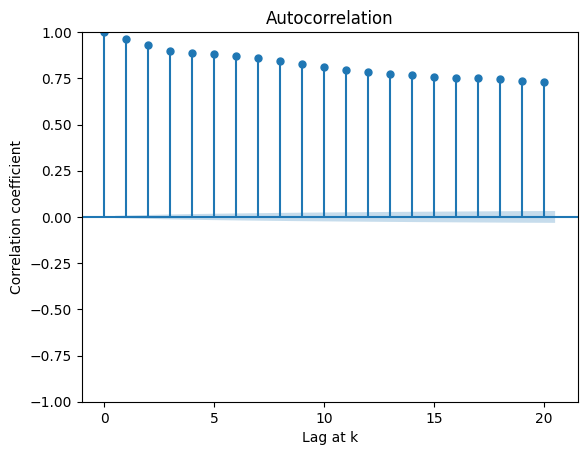

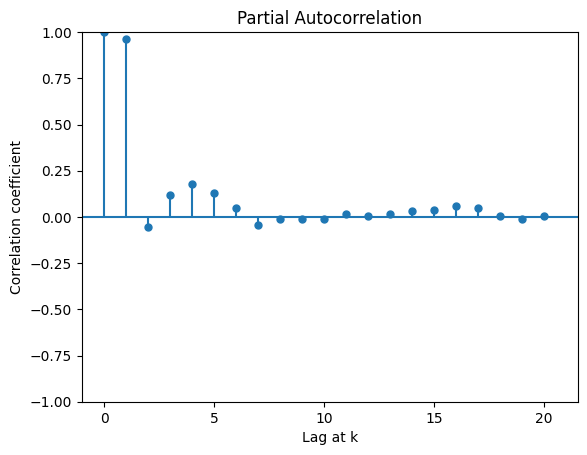

In [36]:
sv = StationnaryViz(choosed_df[:100000], TARGET)
# sv.plot_target()
sv.plot_autocorrelation_target()
sv.plot_partial_autocorrelation_target()


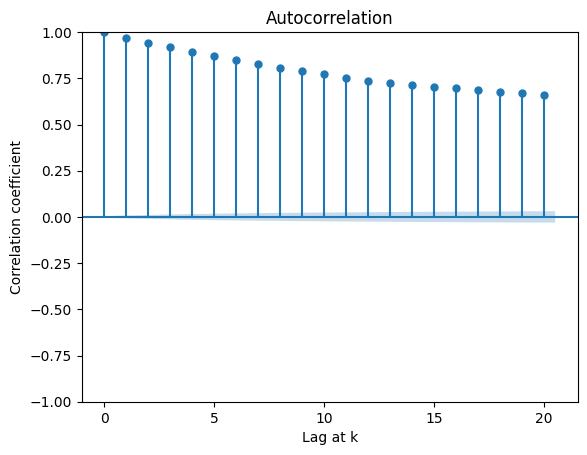

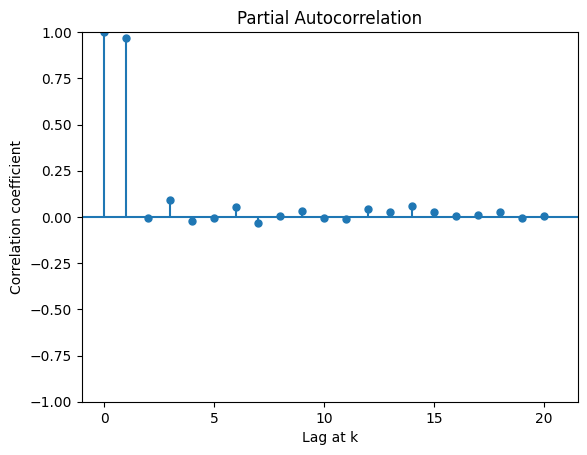

In [37]:
sv = StationnaryViz(choosed_df[-100000:], TARGET)
# sv.plot_target()
sv.plot_autocorrelation_target()
sv.plot_partial_autocorrelation_target()


### 6.2 ADF, KPSS, PP

D'après les différents tests de stationnarité, nous pouvons conclure à la stationnarité de la série.

In [38]:
st = StationarityTest(choosed_df[:100000])
st.adf_test([TARGET])
st.kpss_test([TARGET])
st.pp_test([TARGET])


ADF test pour Global_active_power_Wh:
ADF statistique: -16.3796638002048
p-value: 2.759358304366419e-29
Valeurs critiques: {'1%': -3.4304154398333235, '5%': -2.861568923380865, '10%': -2.5667853949035773}
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 

KPSS test pour Global_active_power_Wh:
KPSS statistique: 1.2653991783866485
p-value: 0.01
Lag utilisé: 175
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 



/Users/sarrabenyahia/Documents/GitHub/deep-q-learning-time-series/.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Phillips-Perron test pour Global_active_power_Wh:
ADF statistique: -16.447638107003538
p-value: 0.0
Lag utilisé: 68
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 



In [39]:
st = StationarityTest(choosed_df[100001:200000])
st.adf_test([TARGET])
st.kpss_test([TARGET])
st.pp_test([TARGET])


ADF test pour Global_active_power_Wh:
ADF statistique: -18.97704276553453
p-value: 0.0
Valeurs critiques: {'1%': -3.430415440488197, '5%': -2.861568923670306, '10%': -2.566785395057637}
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 

KPSS test pour Global_active_power_Wh:
KPSS statistique: 0.6748792776610859
p-value: 0.015829156576264915
Lag utilisé: 173
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 

Phillips-Perron test pour Global_active_power_Wh:
ADF statistique: -18.99899695050956
p-value: 0.0
Lag utilisé: 68
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 



In [40]:
st = StationarityTest(choosed_df[-100000:])
st.adf_test([TARGET])
st.kpss_test([TARGET])
st.pp_test([TARGET])


ADF test pour Global_active_power_Wh:
ADF statistique: -18.536414836853666
p-value: 2.100141463592367e-30
Valeurs critiques: {'1%': -3.4304154398333235, '5%': -2.861568923380865, '10%': -2.5667853949035773}
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 

KPSS test pour Global_active_power_Wh:
KPSS statistique: 0.6039269215564065
p-value: 0.022279370767599407
Lag utilisé: 173
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 

Phillips-Perron test pour Global_active_power_Wh:
ADF statistique: -18.61015872631036
p-value: 0.0
Lag utilisé: 68
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 



**Lorsqu'on regarde par heure:**  
La présence de saisonnalité peut expliquer le résultat du test KPSS, qui a montré que l'hypothèse nulle de non-stationnarité ne pouvait pas être rejetée. Le test KPSS est souvent sensible aux effets de saisonnalité dans les séries chronologiques, car il teste l'hypothèse que la moyenne de la série est constante sur toute la période d'observation, ce qui peut ne pas être le cas si la série présente une saisonnalité.

Dans notre cas, les tests ADF et Phillips-Perron ont indiqué que la série est stationnaire, tandis que le test KPSS a indiqué que la série est non stationnaire. Les tests ADF et Phillips-Perron sont des tests paramétriques qui testent l'hypothèse de présence de racine unitaire dans la série chronologique, tandis que le test KPSS est un test non paramétrique qui test l'hypothèse de l'absence de racine unitaire dans la série.

Une explication possible pour les résultats contradictoires est que la série chronologique est proche d'être stationnaire, mais pas complètement. Dans de tels cas, les tests paramétriques peuvent indiquer que la série est stationnaire, tandis que le test non paramétrique peut indiquer une non-stationnarité marginale.

Cela nous a conduit à travailler plutôt avec une granularité en minutes

> Train-Test-OOT Split

In [41]:
# Pour éviter tout biais dans la mesure des performances, nous créons des ensembles de données d'entraînement, de test et hors du temps de manière chronologique.

# Créer des indices pour diviser les données.
num_rows = len(choosed_df)
train_size = 0.7
test_size = 0.2
idx_train = int(num_rows * train_size)
idx_test = idx_train + int(num_rows * test_size)

# Diviser les données en ensembles d'entraînement, de test et hors du temps.
train = choosed_df.iloc[:idx_train]
test = choosed_df.iloc[idx_train:idx_test]
oot = choosed_df.iloc[idx_test:]

# Séparer les variables de caractéristiques et la variable cible pour chaque ensemble.
X_train = train.drop(columns=TARGET)
y_train = train[TARGET]
X_test = test.drop(columns=TARGET)
y_test = test[TARGET]
X_oot = oot.drop(columns=TARGET)
y_oot = oot[TARGET]

# Imprimer le nombre d'observations dans chaque ensemble.
print(
    f"Il y a {X_train.shape[0]} observations dans l'ensemble d'entraînement.")
print(f"Il y a {X_test.shape[0]} observations dans l'ensemble de test.")
print(f"Il y a {X_oot.shape[0]} observations dans l'ensemble hors du temps.")


Il y a 1404256 observations dans l'ensemble d'entraînement.
Il y a 401216 observations dans l'ensemble de test.
Il y a 200609 observations dans l'ensemble hors du temps.


> Features selection

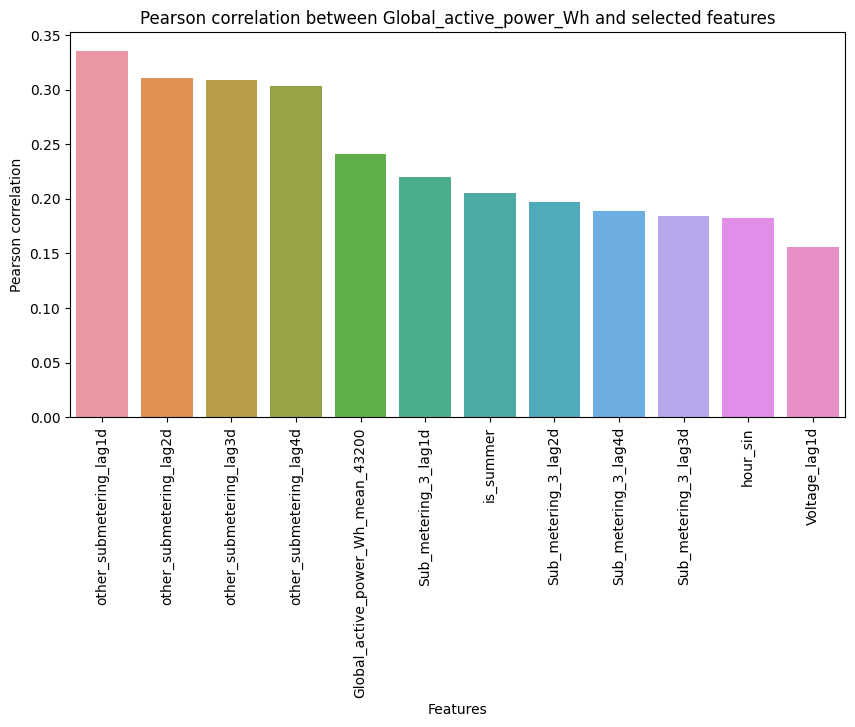

In [42]:
features = filter_correlated_variables(
    train, TARGET, corr_measure="pearson", min_corr=0.15, max_corr=0.85, max_var_corr=0.7)


> Dataframe final

In [43]:
os.makedirs('./../data/train_test_oot/', exist_ok=True)

X_train[features].to_pickle('./../data/train_test_oot/X_train.pkl')
X_test[features].to_pickle('./../data/train_test_oot/X_test.pkl')
X_oot[features].to_pickle('./../data/train_test_oot/X_oot.pkl')

y_train.to_pickle('./../data/train_test_oot/y_train.pkl')
y_test.to_pickle('./../data/train_test_oot/y_test.pkl')
y_oot.to_pickle('./../data/train_test_oot/y_oot.pkl')


In [44]:
X_train = pd.read_pickle('./../data/train_test_oot/X_train.pkl')
X_test = pd.read_pickle('./../data/train_test_oot/X_test.pkl')
X_oot = pd.read_pickle('./../data/train_test_oot/X_oot.pkl')

y_train = pd.read_pickle('./../data/train_test_oot/y_train.pkl')
y_test = pd.read_pickle('./../data/train_test_oot/y_test.pkl')
y_oot = pd.read_pickle('./../data/train_test_oot/y_oot.pkl')


---

## 7. Sélection de différents modèles (explications des critères de sélection, choix de la métrique...)

> Benchmark naïf des 24 dernières heures et Benchmark saisonnier

Utiliser des modèles simples et naïfs pour établir une référence de performance peut être un bon point de départ pour comprendre les défis que les modèles plus avancés devront relever. Ces modèles nous aident également à identifier les limites potentielles de la série temporelle.

Le modèle naïf moyen consiste à prédire la valeur future comme étant la moyenne des valeurs passées de la série temporelle. C'est un peu comme si on prévoyait que demain sera similaire à la moyenne des jours précédents. Ce modèle est facile à comprendre, mais il ne tient pas compte des variations ou des tendances qui peuvent survenir dans la série temporelle.

Le modèle naïf saisonnier est basé sur l'hypothèse que la saisonnalité de la série temporelle est stable d'une année à l'autre. C'est comme si on prévoyait que demain serait similaire à la même période de l'année précédente. Ce modèle peut être utile pour les séries temporelles saisonnières, mais il peut ne pas être efficace si les saisons varient beaucoup ou si des changements significatifs se produisent dans la série temporelle.

MSE benchmark naïf saisonnier = 585.98
MSE benchmark naïf moyen = 383.03


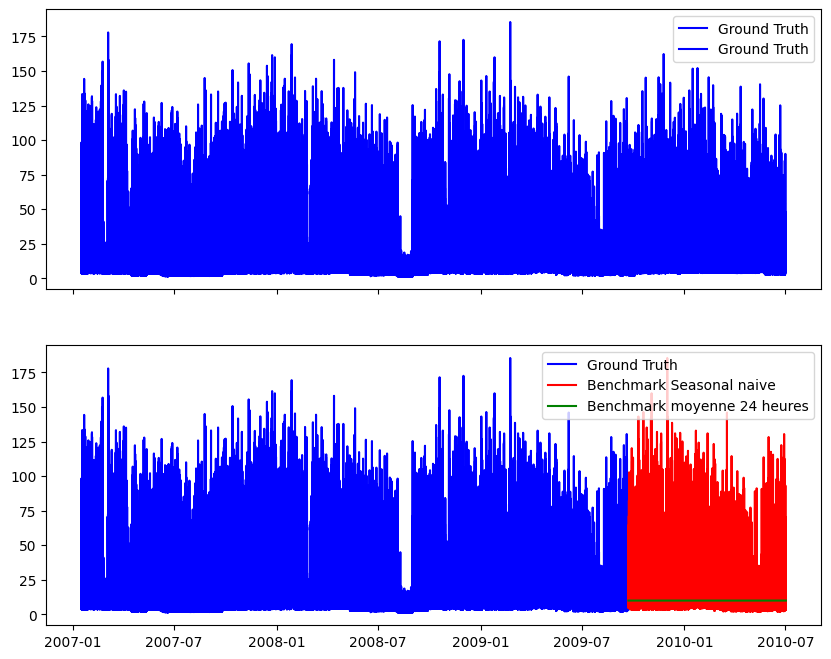

In [45]:
perf_summary = dict()

# définir les variables
num_hours = 24  # nombre d'heures pour la moyenne naïve
num_samples = X_test.shape[0]  # nombre d'échantillons de test
target_column = 'Global_active_power_Wh'  # nom de la colonne cible

# moyenne naïve
last_24_hours_mean = np.mean(train[target_column][-num_hours:])
y_pred_mean = np.ones(num_samples) * last_24_hours_mean
mse_mean = mean_squared_error(y_test, y_pred_mean)
perf_summary['Naive mean 24 hours'] = mse_mean

# saisonnière naïve
y_pred_seas = train[target_column][-num_samples:]
mse_seas = mean_squared_error(y_test, y_pred_seas)
perf_summary['Seasonal naive'] = mse_seas

# tracer la courbe de la vérité au sol et les prédictions
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(train.index, train[target_column], c='b', label='Ground Truth')
axes[0].plot(X_test.index, y_test, c='b', label='Ground Truth')
axes[0].legend()
axes[1].plot(train.index, train[target_column], c='b', label='Ground Truth')
axes[1].plot(X_test.index, y_pred_seas, c='r',
             label='Benchmark Seasonal naive')
axes[1].plot(X_test.index, y_pred_mean, c='g',
             label='Benchmark moyenne 24 heures')
axes[1].legend()

# afficher les résultats
print(f"MSE benchmark naïf saisonnier = {mse_seas:.2f}")
print(f"MSE benchmark naïf moyen = {mse_mean:.2f}")


> Modèle de régression

Après avoir mis en place nos modèle benchmark, nous allons ajuster une régression linéaire multiple avec la variable de sortie "Global_active_power_Wh" et 11 variables d'entrée: "Sub_metering_3_lag2d", "other_submetering_lag3d", "Sub_metering_3_lag4d", "hour_sin", "Voltage_lag1d", "Global_active_power_Wh_mean_43200", "other_submetering_lag4d", "other_submetering_lag2d", "is_summer", "Sub_metering_3_lag1d", et "other_submetering_lag1d", et  "Sub_metering_3_lag3d".

In [46]:
X_train.columns


Index(['other_submetering_lag4d', 'Voltage_lag1d', 'other_submetering_lag2d',
       'other_submetering_lag1d', 'Global_active_power_Wh_mean_43200',
       'other_submetering_lag3d', 'Sub_metering_3_lag4d', 'hour_sin',
       'Sub_metering_3_lag2d', 'Sub_metering_3_lag3d', 'is_summer',
       'Sub_metering_3_lag1d'],
      dtype='object')

In [47]:
import statsmodels.formula.api as sm

model = sm.ols(formula='Global_active_power_Wh ~  Sub_metering_3_lag2d + other_submetering_lag3d + Sub_metering_3_lag4d + hour_sin + Voltage_lag1d + Global_active_power_Wh_mean_43200 + other_submetering_lag4d + other_submetering_lag2d + is_summer + Sub_metering_3_lag1d + other_submetering_lag1d + Sub_metering_3_lag3d', data=train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Global_active_power_Wh   R-squared:                       0.229
Model:                                OLS   Adj. R-squared:                  0.229
Method:                     Least Squares   F-statistic:                 3.478e+04
Date:                    Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                            22:27:34   Log-Likelihood:            -5.8619e+06
No. Observations:                 1404256   AIC:                         1.172e+07
Df Residuals:                     1404243   BIC:                         1.172e+07
Df Model:                              12                                         
Covariance Type:                nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            83.1728      1.113     74.756      0.000      80.992      85.353
Sub_metering_3_lag2d                  0.1576      0.002     90.688      0.000       0.154       0.161
other_submetering_lag3d               0.1589      0.002     95.779      0.000       0.156       0.162
Sub_metering_3_lag4d                  0.1482      0.002     85.711      0.000       0.145       0.152
hour_sin                             -2.4563      0.020   -123.681      0.000      -2.495      -2.417
Voltage_lag1d                        -0.3297      0.005    -70.866      0.000      -0.339      -0.321
Global_active_power_Wh_mean_43200     0.2437      0.004     65.233      0.000       0.236       0.251
other_submetering_lag4d               0.1504      0.002     91.565      0.000       0.147       0.154
other_submetering_lag2d               0.1523      0.002     91.747      0.000       0.149       0.156
is_summer                            -1.9533      0.038    -51.453      0.000      -2.028      -1.879
Sub_metering_3_lag1d                  0.2031      0.002    114.092      0.000       0.200       0.207
other_submetering_lag1d               0.2151      0.002    126.784      0.000       0.212       0.218
Sub_metering_3_lag3d                  0.1204      0.002     69.272      0.000       0.117       0.124
==============================================================================
Omnibus:                   529791.009   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2496881.772
Skew:                           1.799   Prob(JB):                         0.00
Kurtosis:                       8.453   Cond. No.                     2.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MSE = 223.28


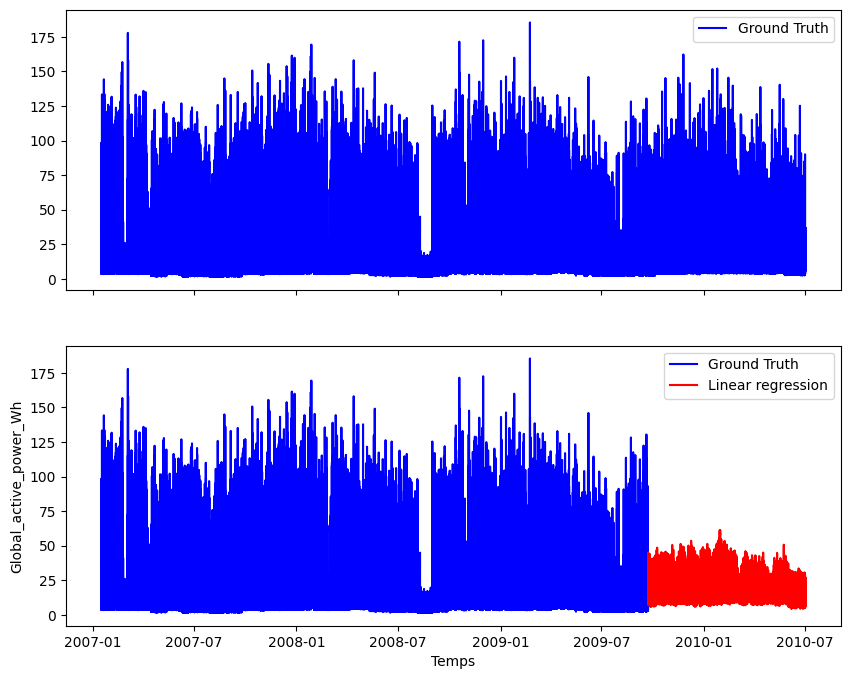

In [48]:
y_pred_lin = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred_lin)
print("MSE = %.2f" % MSE)
perf_summary['Regression Lineaire'] = MSE

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(train.index, train[target_column], c='b', label='Ground Truth')
axes[0].plot(X_test.index, y_test, c='b')
axes[0].legend()
axes[1].plot(train.index, train[target_column], c='b', label='Ground Truth')
plt.plot(X_test.index, y_pred_lin, c='r', label='Linear regression')
axes[1].legend()
plt.xlabel('Temps')
plt.ylabel('Global_active_power_Wh')
plt.show()


Les résultats montrent les performances d'un modèle qui tente de prédire une variable de sortie appelée "Global_active_power_Wh", à l'aide de 12 variables d'entrée. Le coefficient de détermination de 0,229 indique que le modèle explique environ 23% de la variation de la variable de sortie, ce qui n'est pas très bon.

Le F-statistic est élevé, ce qui est une bonne nouvelle, car cela indique que le modèle est significatif et que les variables d'entrée ont une influence sur la variable de sortie. Les valeurs p, qui mesurent la probabilité que les variables d'entrée soient nulles, sont très faibles pour toutes les variables, ce qui est une autre bonne nouvelle.

Le coefficient de chaque variable d'entrée indique la direction et la force de l'effet sur la variable de sortie. Par exemple, le coefficient de "Sub_metering_3_lag2d" suggère que si cette variable augmente de 1 unité, la variable de sortie augmentera de 0,1576 unités. De même, le coefficient de "hour_sin" suggère qu'une augmentation de 1 unité de cette variable entraîne une diminution de la variable de sortie de 2,4563 unités.

Les valeurs de l'Omnibus et du Jarque-Bera testent si les résidus (les différences entre les prédictions du modèle et les valeurs réelles) suivent une distribution normale. Les résultats indiquent que les résidus ne suivent pas une distribution normale, ce qui peut poser des problèmes pour le modèle.

Enfin, le conditionnement mesure la corrélation entre les variables d'entrée. Dans ce cas, les variables d'entrée sont corrélées, mais pas suffisamment pour rendre le modèle instable.

En conséquence, même si la MSE s'améliore par rapport à notre benchmark, il peut être judicieux d'envisager d'autres modèles plus complexes ou de revoir les variables d'entrée pour améliorer les performances de prédiction. Cependant, cela dépend également du contexte de l'application et des performances requises pour répondre aux objectifs. Dans l'ensemble, la décision de conserver ou de rejeter ce modèle dépend de l'analyse du contexte et des performances souhaitées.

> Xgboost

XGBoost (eXtreme Gradient Boosting) est une méthode d'apprentissage ensembliste basée sur la construction d'arbres de décision. Elle combine plusieurs modèles faibles en un modèle fort en utilisant le boosting, qui est une technique d'apprentissage supervisé itérative qui met l'accent sur les échantillons mal classés dans l'ensemble d'entraînement.

Dans XGBoost, chaque arbre de décision est construit en minimisant une fonction de coût qui mesure la différence entre les prédictions et les vraies valeurs de la variable de sortie. Cette fonction de coût comprend deux termes : le premier mesure l'erreur de prédiction, tandis que le deuxième décourage les arbres complexes qui peuvent entraîner un surajustement.

L'optimisation de la fonction de coût est effectuée à l'aide d'une descente de gradient stochastique régularisée, ce qui permet une convergence rapide et efficace vers les paramètres optimaux.

Le modèle final est obtenu en combinant les prédictions de tous les arbres de décision construits. Les prédictions sont pondérées en fonction de leur précision, et une régularisation L1 et L2 est utilisée pour éviter le surajustement.

La formule générale pour les prédictions d'un modèle XGBoost est la suivante :

$$\hat{y}_i = \sum_{k=1}^K f_k(x_i)$$

où $\hat{y}_i$ est la prédiction de la variable de sortie pour l'observation $i$, $K$ est le nombre d'arbres de décision dans le modèle, et $f_k(x_i)$ est la prédiction de l'arbre de décision $k$ pour l'observation $i$.

Chaque arbre de décision est représenté par une fonction $f_k$, qui prend les variables d'entrée $x_i$ comme entrée et renvoie une prédiction $f_k(x_i)$. Chaque fonction $f_k$ est construite par la somme des prédictions de chaque feuille de l'arbre :

$$f_k(x_i) = \sum_{j=1}^T c_{j,k} \cdot \mathbb{I}(x_i \in R_{j,k})$$

où $T$ est le nombre de feuilles de l'arbre, $c_{j,k}$ est le poids associé à la feuille $j$ de l'arbre $k$, et $\mathbb{I}(x_i \in R_{j,k})$ est une fonction indicatrice qui prend la valeur 1 si $x_i$ appartient à la région $R_{j,k}$ définie par la feuille $j$ de l'arbre $k$, et 0 sinon.

MSE = 217.99


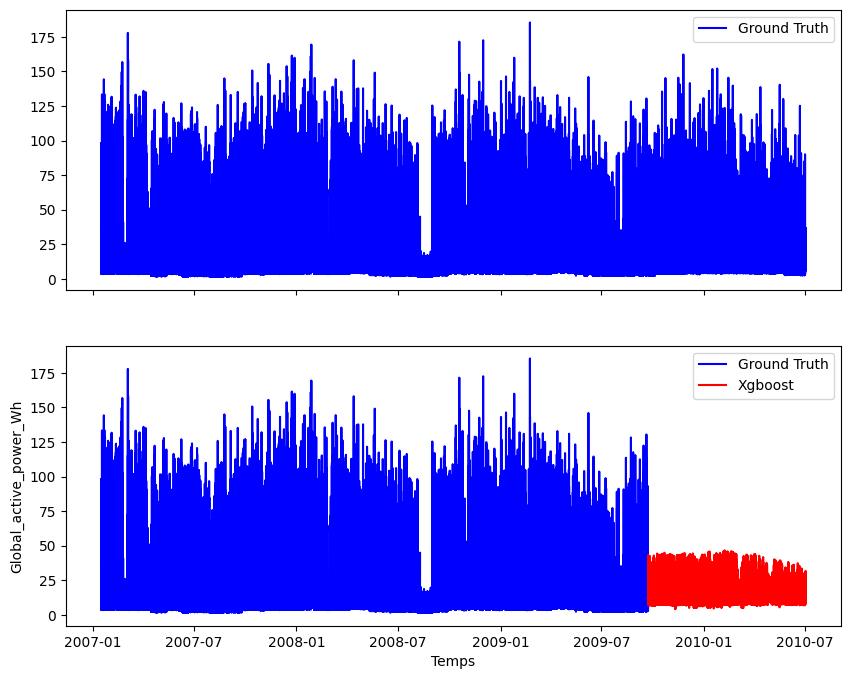

In [49]:
# Instantiate the GradientBoostingRegressor model with some hyperparameters
model = GradientBoostingRegressor(
    loss='squared_error', learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)
# Fit the model to the training data
model.fit(X_train, y_train)
# Predict on the testing data
y_pred_xgboost = model.predict(X_test)


# Calculate the mean squared error
MSE_xgboost = mean_squared_error(y_test, y_pred_xgboost)
print("MSE = %.2f" % MSE_xgboost)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(train.index, train[target_column], c='b', label='Ground Truth')
axes[0].plot(X_test.index, y_test, c='b')
axes[0].legend()
axes[1].plot(train.index, train[target_column], c='b', label='Ground Truth')
plt.plot(X_test.index, y_pred_xgboost, c='r', label='Xgboost')
axes[1].legend()
plt.xlabel('Temps')
plt.ylabel('Global_active_power_Wh')
plt.show()


> ConvLSTM

La structure du modèle ConvLSTM2D est basée sur les LSTM (Long Short-Term Memory), qui sont des réseaux de neurones récurrents capables de prendre en compte les dépendances temporelles dans les données d'entrée. Toutefois, les ConvLSTM2D étendent cette capacité aux relations spatiales des données. Les LSTM et ConvLSTM2D partagent une structure similaire, mais avec quelques différences importantes.

Le LSTM utilise des portes (gates) pour réguler l'information qui est transmise d'une cellule à une autre. Les portes sont des couches de neurones qui prennent en entrée les sorties de la couche précédente, ainsi que les données d'entrée, et qui produisent des valeurs comprises entre 0 et 1. Ces valeurs sont ensuite multipliées par l'état de la cellule pour contrôler la quantité d'information qui est transmise.

La formule de mise à jour pour un LSTM est la suivante :

$$i_t = \sigma(W_i . [h_{t-1}, x_t] + b_i)$$
$$f_t = \sigma(W_f . [h_{t-1}, x_t] + b_f)$$
$$o_t = \sigma(W_o . [h_{t-1}, x_t] + b_o)$$
$$c_t = f_t * c_{t-1} + i_t * tanh(W_c . [h_{t-1}, x_t] + b_c)$$
$$h_t = o_t * tanh(c_t)$$

Où :

- $x_t$ est l'entrée au temps t
- $h_{t-1}$ est la sortie de la couche précédente au temps t-1
- $i_t, f_t,$ et $o_t$ sont respectivement les vecteurs d'entrée, de l'oubli, et de sortie
- $c_t$ est l'état de la cellule à l'instant t
- $W_i, W_f, W_o, W_c $ sont des poids à apprendre pour chaque porte et chaque état de cellule
- $b_i, b_f, b_o, b_c$sont les biais correspondant à chaque porte et chaque état de cellule

$\sigma$ est la fonction d'activation sigmoid, tanh est la fonction d'activation tanh
Les ConvLSTM2D étendent cette idée en ajoutant des convolutions 2D dans les LSTM. Les convolutions 2D permettent de prendre en compte les relations spatiales des données, en calculant des convolutions sur des fenêtres de taille spécifiée dans les données d'entrée.

La formule de mise à jour pour un ConvLSTM2D est la suivante :

$$i_{t} = \sigma(W_i * X_{t} + U_i * H_{t-1} + b_i)$$
$$f_{t} = \sigma(W_f * X_{t} + U_f * H_{t-1} + b_f)$$
$$o_{t} = \sigma(W_o * X_{t} + U_o * H_{t-1} + b_o)$$
$$C_{t} = f_{t} * C_{t-1} + i_{t} * tanh(W_c * X_{t} + U_c * H_{t-1} + b_c)$$
$$H_{t} = o_{t} * tanh(C_{t})$$

Où :

- $X_t$ est l'entrée au temps t, qui est une tensor 5D avec les dimensions (batch_size, num_frames, rows, cols, num_channels), où batch_size représente le nombre d'échantillons dans chaque batch, num_frames est le nombre de frames dans chaque séquence temporelle, rows et cols représentent la hauteur et la largeur des données d'entrée, et num_channels est le nombre de canaux dans les données d'entrée.
- $H_{t-1}$ est la sortie de la couche précédente au temps t-1, qui est également un tensor 5D avec les mêmes dimensions que $X_t$.
- $i_t, f_t, et o_t$ sont les vecteurs d'entrée, d'oubli et de sortie, respectivement, qui sont des tensors 5D avec des dimensions de (batch_size, 1, rows, cols, num_filters) où num_filters représente le nombre de filtres (neurones) dans la couche.
- $C_t$ est l'état de la cellule à l'instant t, qui est également un tensor 5D avec des dimensions de (batch_size, 1, rows, cols, num_filters).
- $W_i, W_f, W_o, W_c, U_i, U_f, U_o, U_c$ sont des poids à apprendre pour chaque porte et chaque état de cellule, qui sont des tensors 5D de la forme (kernel_rows, kernel_cols, input_filters, output_filters).
- $b_i, b_f, b_o, b_c$ sont les biais correspondant à chaque porte et chaque état de cellule, qui sont des tensors 1D avec la forme (num_filters).
- $\sigma$ est la fonction d'activation sigmoid, tanh est la fonction d'activation tangente hyperbolique.


Dans le modèle présenté, trois couches ConvLSTM2D sont empilées les unes sur les autres. La première couche a 64 filtres, une taille de noyau de (1,2), et une activation linéaire. La deuxième couche a 32 filtres, une taille de noyau de (1,2), et une activation sigmoïde. La troisième couche a 16 filtres, une taille de noyau de (1,2), et une activation tanh. Chaque couche est suivie d'une couche Dropout pour éviter le surapprentissage.

Enfin, une couche Flatten est ajoutée pour convertir les sorties de la dernière couche ConvLSTM2D en un vecteur. Deux couches Dense sont ensuite ajoutées, la première avec 64 neurones et une activation relu, et la deuxième avec une sortie unique pour la régression. Le modèle est compilé avec une perte mean_squared_error et l'optimiseur Adam.

In [50]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Dense, Flatten, Dropout
from sklearn.preprocessing import StandardScaler


In [51]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the features into the required shape for ConvLSTM2D
X_train_reshaped = X_train_scaled.reshape(
    (X_train_scaled.shape[0], 1, 1, X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape(
    (X_test_scaled.shape[0], 1, 1, X_test_scaled.shape[1], 1))

# Define the model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='linear',
          input_shape=(1, 1, X_train_scaled.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(ConvLSTM2D(filters=32, kernel_size=(1, 2),
          activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))
model.add(ConvLSTM2D(filters=16, kernel_size=(1, 2),
          activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=5,
                    batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
score = model.evaluate(X_test_reshaped, y_test, verbose=0)
print('Test loss:', score)


Epoch 1/10


2023-04-18 22:30:54.044463: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43883/43883 [==============================] - 244s 6ms/step - loss: 255.4629 - val_loss: 218.8339
Epoch 2/10
43883/43883 [==============================] - 252s 6ms/step - loss: 246.3892 - val_loss: 218.2279
Epoch 3/10
43883/43883 [==============================] - 252s 6ms/step - loss: 243.9720 - val_loss: 218.7472
Epoch 4/10
43883/43883 [==============================] - 254s 6ms/step - loss: 242.7376 - val_loss: 217.7874
Epoch 5/10
43883/43883 [==============================] - 255s 6ms/step - loss: 242.1241 - val_loss: 218.5207
Epoch 6/10
43883/43883 [==============================] - 261s 6ms/step - loss: 241.5861 - val_loss: 217.2547
Epoch 7/10
43883/43883 [==============================] - 248s 6ms/step - loss: 241.1639 - val_loss: 217.6292
Epoch 8/10
43883/43883 [==============================] - 230s 5ms/step - loss: 240.7541 - val_loss: 217.9938
Epoch 9/10
43883/43883 [==============================] - 223s 5ms/step - loss: 240.3616 - val_loss: 217.3060
Epoch 10/10
43883/438

In [52]:
# Save the model using pickle
with open('./../data/convlstm/convlstm.pkl', 'wb') as file:
    pickle.dump(model, file)


In [53]:
# Generate predictions on the test set
y_pred_clstm = model.predict(X_test_reshaped)


12538/12538 [==============================] - 15s 1ms/step


MSE = 217.18


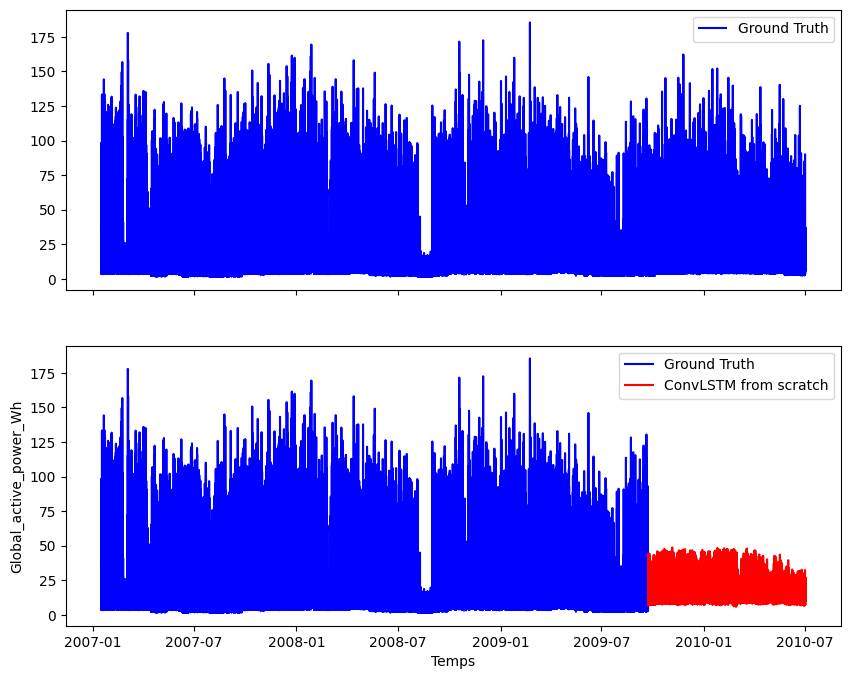

In [54]:
import matplotlib.pyplot as plt

MSE = mean_squared_error(y_test, y_pred_clstm)
print("MSE = %.2f" % MSE)


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(train.index, train[target_column], c='b', label='Ground Truth')
axes[0].plot(X_test.index, y_test, c='b')
axes[0].legend()
axes[1].plot(train.index, train[target_column], c='b', label='Ground Truth')
plt.plot(X_test.index, y_pred_clstm, c='r', label='ConvLSTM from scratch')
axes[1].legend()
plt.xlabel('Temps')
plt.ylabel('Global_active_power_Wh')
plt.show()


> Prophet : 

Prophet est un modèle de prévision de séries temporelles développé par Facebook qui permet de modéliser les effets saisonniers, les tendances non linéaires et les effets de vacances. Il est particulièrement utile pour les séries temporelles avec des effets saisonniers forts et plusieurs saisons de données historiques. Prophet est également capable de gérer les données manquantes, les changements de tendance et les valeurs aberrantes. De plus, il est facile à utiliser et à mettre en œuvre, et est disponible en open source en Python.

Cependant, nous avons rencontré des problèmes techniques avec les puces M2 que nous utilisons, ce qui nous a empêché de mettre en place le modèle Prophet pour le moment. En effet, notre notebook est codé sous Python 3.10, ce qui peut provoquer des problèmes de compatibilité avec certaines bibliothèques, dont Prophet. Bien que nous ayons essayé plusieurs solutions alternatives pour contourner ces problèmes, telles que l'utilisation d'une version antérieure de Python ou d'autres modèles de prévision de séries temporelles compatibles avec Python 3.10, nous avons rencontré des difficultés supplémentaires avec la puce M2 qui ont rendu ces solutions impraticables.

Ces problèmes d'incompatibilité technique sont liés à la gestion des dépendances des bibliothèques Python, car certains paquets ne sont pas encore mis à jour pour fonctionner avec les dernières versions de la puce M2, ce qui provoque des erreurs lors de l'exécution de notre code. Nous sommes conscients des inconvénients que cela peut causer, et nous continuons à chercher des solutions pour résoudre ces problèmes techniques et pouvoir utiliser Prophet dans nos prévisions de séries temporelles à l'avenir.


Nous avons réussi à entraîner le modèle en utilisant un processeur Intel, mais en raison du grand volume de données, le notebook plantait lors de la phase de prédiction.

In [ ]:
# from prophet import Prophet

# prophet_df = y_train.reset_index()
# prophet_df.rename(columns={'datetime':'ds', 'Global_active_power_Wh':'y'}, inplace=True)
# prophet_df.head()

# m = Prophet()
# m.fit(prophet_df)

# # Load the saved model from a file
# with open('./../data/prophet/prophet_model.pkl', 'rb') as f:
#     m = pickle.load(f)

# future = m.make_future_dataframe(periods=288*60*24, freq='1min')
# future.tail()

# forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## 8. Evaluation de la performance des modèles (recherche d'hyperparamètres, contrôle de l’overfitting, comparaison des performances) sur différents horizons de prédiction

Pour notre première sélection, nous allons prendre en compte les modèles qui offrent les meilleurs résultats en termes de performance de MSE. Cela nous permettra d'économiser du temps sur l'hyperparamétrisation de Gridsearch, qui peut être chronophage sur certains modèles, et de renforcer au maximum nos meilleurs modèles.

Nous veillerons à prendre en compte l'overfitting que nous pouvons déjà constater sur le ConvLSTM, en observant la différence entre la loss et la val_loss. Nous utiliserons cette hyperparamétrisation pour éviter ce problème.

Nous allons chercher à optimiser les modèles XgBoost et ConvLSTM, qui ont produit les plus petites MSE sans hyper-paramétrisation. Nous allons explorer différentes options d'optimisation pour améliorer encore plus la performance de ces modèles, afin de produire des prévisions plus précises et fiables.

> Hyperparamétrisation du Xgboost

Nous lançons un grid-search sur les Xgboost sur les hyper-paramètres suivants : 

- Le  learning_rate contrôle la vitesse à laquelle le modèle se rapproche de la solution optimale. Si la valeur de learning_rate est faible, le modèle se déplace lentement vers la solution optimale, ce qui peut améliorer la généralisation.

- Le n_estimators définit le nombre d'arbres que le modèle construit lors de l'entraînement. Plus le nombre d'arbres est élevé, plus le modèle est complexe et peut potentiellement sur-apprendre.

- Le max_depth définit la profondeur maximale de chaque arbre de décision dans le modèle. Une profondeur plus grande permet au modèle de mieux s'adapter aux données d'entraînement, mais cela peut également augmenter le risque de sur-apprentissage.

- Les paramètres reg_alpha et reg_lambda contrôlent la force de la régularisation L1 et L2 appliquée aux coefficients de chaque arbre dans le modèle. L'ajout de régularisation peut aider à éviter le sur-apprentissage en empêchant les coefficients de prendre des valeurs extrêmes.


En utilisant cette méthode, nous explorons différentes combinaisons d'hyperparamètres afin de trouver la configuration optimale qui permet d'obtenir le meilleur compromis entre précision et généralisation. Cela permet d'obtenir un modèle qui est capable de bien généraliser à de nouvelles données, tout en ayant une bonne précision sur les données d'entraînement.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Define the model
model = GradientBoostingRegressor(loss='squared_error', random_state=42)

# Define the hyperparameters to search over
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'min_child_weight'
}


# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid.fit(X_train, y_train)

# Get the best estimator from the grid search
best_xgboost_model = grid.best_estimator_


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


ValueError: Invalid parameter 'reg_alpha' for estimator GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=50,
                          random_state=42). Valid parameters are: ['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'].

> Hyperparamétrisation du ConvLSTM

Dans ce code, nous définissons une grille de recherche d'hyperparamètres pour un modèle de Convolutional LSTM (ConvLSTM). Les hyperparamètres inclus dans la grille de recherche sont les suivants:

- filters_1, filters_2 et filters_3 sont les nombres de filtres à utiliser dans les trois couches de ConvLSTM. Une valeur plus grande implique une représentation plus complexe, mais peut également augmenter le risque de sur-apprentissage.

- kernel_size_1, kernel_size_2 et kernel_size_3 sont les tailles de noyau à utiliser dans les trois couches de ConvLSTM. Une taille plus grande permet d'examiner un contexte plus large, mais peut également augmenter la complexité du modèle.

- activation_1, activation_2 et activation_3 sont les fonctions d'activation à utiliser dans les trois couches de ConvLSTM. Les fonctions d'activation permettent au modèle de modéliser des relations non linéaires entre les entrées et les sorties.

- dense_units est le nombre d'unités dans la couche de sortie dense. Une valeur plus grande permet de capturer des relations plus complexes entre les entrées et les sorties, mais peut également augmenter la complexité du modèle.

- dropout_rate est le taux de dropout à utiliser dans la couche dense. Le dropout permet d'éviter le sur-apprentissage en supprimant aléatoirement des connexions entre les neurones de la couche dense.

- optimizer est l'algorithme d'optimisation à utiliser pour entraîner le modèle. Les algorithmes d'optimisation permettent de trouver les valeurs optimales pour les poids du modèle.

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import ConvLSTM2D, Dropout, Flatten, Dense
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler

# Define a function to create the model with hyperparameters


def create_model(filters_1=64, kernel_size_1=(1, 2), activation_1='linear',
                 filters_2=32, kernel_size_2=(1, 2), activation_2='sigmoid',
                 filters_3=16, kernel_size_3=(1, 2), activation_3='tanh',
                 dense_units=64, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(ConvLSTM2D(filters=filters_1, kernel_size=kernel_size_1,
                         activation=activation_1, input_shape=(1, 1, X_train_scaled.shape[1], 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(ConvLSTM2D(filters=filters_2, kernel_size=kernel_size_2,
                         activation=activation_2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(ConvLSTM2D(filters=filters_3, kernel_size=kernel_size_3,
                         activation=activation_3, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the features into the required shape for ConvLSTM2D
X_train_reshaped = X_train_scaled.reshape(
    (X_train_scaled.shape[0], 1, 1, X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape(
    (X_test_scaled.shape[0], 1, 1, X_test_scaled.shape[1], 1))

# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=10,
                       batch_size=32, verbose=0)

# Define the hyperparameters to search over
param_grid = {
    'filters_1': [32, 64],
    'kernel_size_1': [(1, 2), (1, 3)],
    'activation_1': ['linear', 'relu'],
    'filters_2': [16, 32],
    'kernel_size_2': [(1, 2), (1, 3)],
    'activation_2': ['sigmoid', 'tanh'],
    'filters_3': [8, 16],
    'kernel_size_3': [(1, 2), (1, 3)],
    'activation_3': ['linear', 'relu'],
    'dense_units': [32, 64],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_reshaped, y_train)

#Save best model
best_convLSTM = grid_result.best_estimator_
# Print the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")



> Prédiction sur le split - Out Of Time

In [ ]:
#D'abord pour le xgboost : 
y_pred_xgboost = best_xgboost_model.predict(X_oot)

In [ ]:
# Ensuite pour le convLSTM
y_pred_convLSTM = best_convLSTM.predict(X_oot)

> Comparaison des perfomances

- La normalisation de la MSE permet de comparer la précision de prédiction de différents modèles en utilisant une mesure relative, indépendamment de l'unité de la variable cible. Elle se calcule en divisant la racine carrée de la MSE par l'écart type de la variable cible, et indique combien de fois l'erreur de prédiction est plus grande que l'écart type de la variable cible. Une MSE normalisée proche de 1 signifie que les erreurs de prédiction sont similaires à l'écart type de la variable cible. Si la MSE normalisée est inférieure à 1, cela signifie que les erreurs de prédiction sont plus petites que l'écart type de la variable cible.

- Le coefficient de détermination ($R^2$) : cette mesure évalue la proportion de la variance de la variable cible qui est expliquée par le modèle. Un R² proche de 1 indique que le modèle est capable d'expliquer une grande partie de la variance de la variable cible, tandis qu'un R² proche de 0 indique que le modèle ne parvient pas à expliquer la variance de la variable cible.

- L'erreur absolue moyenne (MAE) : cette mesure évalue la magnitude moyenne des erreurs de prédiction en unités de la variable cible. Elle est calculée en prenant la moyenne des valeurs absolues des erreurs de prédiction. Contrairement à la MSE, la MAE ne pénalise pas autant les grandes erreurs de prédiction, ce qui peut la rendre plus robuste face aux valeurs aberrantes.

- La métrique AIC (Akaike Information Criterion) ou BIC (Bayesian Information Criterion) : ces mesures sont utilisées pour évaluer la qualité du modèle en prenant en compte à la fois la précision de prédiction et la complexité du modèle. Elles permettent de pénaliser les modèles trop complexes qui pourraient surajuster les données. Les modèles avec un AIC ou un BIC plus faible sont considérés comme plus performants.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


def evaluate_model(y_true, y_pred, target_std, num_features, num_samples):
    """
    Évalue un modèle de série temporelle en calculant la normalisation de la MSE, le R², la MAE et l'AIC/BIC.

    Args:
    - y_true (array): les vraies valeurs de la variable cible
    - y_pred (array): les valeurs prédites de la variable cible
    - target_std (float): l'écart type de la variable cible
    - num_features (int): le nombre de features utilisées dans le modèle
    - num_samples (int): le nombre d'échantillons utilisés pour évaluer le modèle

    Returns:
    - dict: un dictionnaire contenant les valeurs normalisées de la MSE, du R², de la MAE et de l'AIC/BIC
    """
    # Calcul de la normalisation de la MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_norm = np.sqrt(mse) / target_std

    # Calcul du R²
    r2 = r2_score(y_true, y_pred)

    # Calcul de la MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calcul de l'AIC/BIC
    k = num_features
    n = num_samples
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)

    # Stockage des résultats dans un dictionnaire
    results = {'Normalized MSE': mse_norm, 'R²': r2,
               'MAE': mae, 'AIC': aic, 'BIC': bic}

    return results


In [ ]:
results_xgboost = evaluate_model(y_oot, y_pred_xgboost, choosed_df.std(), len(model.feature_importances_), X_train.shape[0])

In [ ]:
results_convLSTM = evaluate_model(y_oot, y_pred_convLSTM, choosed_df.std(), X_train_scaled.shape[1] X_train.shape[0])

In [ ]:
# Convert the dictionaries to dataframes
df_xgboost = pd.DataFrame.from_dict(results_xgboost, orient='index', columns=['XGBoost'])
df_convLSTM = pd.DataFrame.from_dict(results_convLSTM, orient='index', columns=['ConvLSTM'])

# Merge the dataframes
df_results = pd.concat([df_xgboost, df_convLSTM], axis=1)
df_results

## 9. Discussion autour de la performance des modèles


## 10. Synthèse et conclusions, pistes d’améliorations envisagées

Dans notre cas, nous avons travaillé avec un jeu de données très particulier. Si bien en premier lieu il avait l'air complet, nous nous sommes rendu compte par la suite qu'en général toutes les variables étaient une transformation de la cible.  

Cela fait que les lags des variables soient très bons pour prédire et cela fait que nos métriques soient très bonnes. En effet, ayant une granularité si précise, la meilleure prédiction de demain est la consommation d'aujourd'hui, sauf lorsque des variables saisonnières rentrent en jeu. Cela n'est surtout pas mauvais, et c'est des bonnes variables explicatives pour le modèle, mais il faudrait changer la loss function pour pénaliser beaucoup la sous-production et essayer de minimiser la sur-production.  

La sous-production pourrait engendrer des coupures éléctriques. Normalement il n'y a pas de problèmes car il y a toujours des batteries et cette petite minute d'intervalle d'adaptation pourrait être facilement gérer par celles-ci. Nous nous sommes demandés si changer l'horizon de prédiction, pour cela il faudrait changer la granularité à journalier. Nous l'avons fait mais nous sommes revenus sur le problème initial de prédiction à la minute, nous le trouvons plus intéréssant et surtout nous avons pensé à utiliser des algorithmes de Deep Learning.

En définitive, nous sommes assez déçus du jeu de données sur lequel nous avons travailler, où les modèles les plus simples sont très performants et tout ce que l'on essaye fait de petits progrès dans la prédiction. Cela nous a permis cependant de travailler avec Prophet ou avec GlounTS (et de travailler le format des données), entre autres, et de nous poser les questions propres aux séries temporélles. 

Il y a plusieurs pistes d'amélioration comme nous avons déjà commenté tout au long du notebook: introduction de nouvelles variables externes comme la prévision de la température pour les prochains jours, le stock disponible de gaz et de pétrole à tout moment, de façon à rendre le projet plus intéréssant, ou d'adapter la loss function.
